In [ ]:
#Shuvani Choudhury(12768553)
#Purpose of Code: Fit VARX-DCC and VARX-GOGARCH models to looks for correlation amongst stock indices and abnormal volatilities

In [208]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.compat import lzip
from scipy import stats
import arch
from statsmodels.stats.diagnostic import het_white
from statistics import stdev
import statsmodels.tsa.stattools as ts
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from sklearn.utils import resample
from pylab import *
from tikzplotlib import save as tikz_save

In [209]:
pip install tikzplotlib

Note: you may need to restart the kernel to use updated packages.


In [210]:
#Install rpy2

import os
os.environ['R_HOME'] = 'C:/Program Files/R/R-3.6.3'      # Edit R version
os.environ['R_USER'] = 'C:/Users/shuva/Documents'      # Edit username and double check location of R directory
os.environ['PATH'] += os.pathsep + r'C:/Program Files/R/R-3.6.3/bin/x64' # Add R executables to PATH

In [211]:
pip install rpy2-2.9.5-cp37-cp37m-win_amd64.whl

Note: you may need to restart the kernel to use updated packages.


In [212]:
pip install tzlocal

Note: you may need to restart the kernel to use updated packages.


In [213]:
#Read excel file and calculate the log-returns
df = pd.read_excel('data.xlsx', index_col=0)
df['log_ret_USA'] = 100*(np.log(df.USA) - np.log(df.USA.shift(1)))
df['log_ret_JAP'] = 100*(np.log(df.Japan) - np.log(df.Japan.shift(1)))
df['log_ret_NL'] = 100*(np.log(df.Netherlands) - np.log(df.Netherlands.shift(1)))
df['log_ret_GER'] = 100*(np.log(df.Germany) - np.log(df.Germany.shift(1)))
df['log_ret_BR'] = 100*(np.log(df.Brazil) - np.log(df.Brazil.shift(1)))
df['log_ret_HK'] = 100*(np.log(df.HK) - np.log(df.HK.shift(1)))
df['log_ret_SA'] = 100*(np.log(df.SA) - np.log(df.SA.shift(1)))
df['log_ret_SK'] = 100*(np.log(df.SK) - np.log(df.SK.shift(1)))
df['log_ret_AU'] = 100*(np.log(df.Australia) - np.log(df.Australia.shift(1)))
df['log_ret_IND'] = 100*(np.log(df.India) - np.log(df.India.shift(1)))
df['log_ret_MSCI'] = 100*(np.log(df.MSCI) - np.log(df.MSCI.shift(1)))
df.head()

USA         Japan  Netherlands    Germany   Brazil  \
Date                                                                       
Dec 03, 2018  2790.370117  22574.759766   523.869995  25.966000  89820.0   
Dec 04, 2018  2700.060059  22036.050781   523.229980  25.200001  88624.0   
Dec 06, 2018  2695.949951  21501.619141   498.920013  24.910000  88846.0   
Dec 07, 2018  2633.080078  21678.679688   503.980011  24.444000  88115.0   
Dec 10, 2018  2637.719971  21219.500000   495.309998  24.350000  85915.0   

                        HK            SA           SK  Australia  \
Date                                                               
Dec 03, 2018  27182.039063  10209.959961  2131.929932  54.180000   
Dec 04, 2018  27260.439453  10263.990234  2114.350098  53.660000   
Dec 06, 2018  26156.380859   9893.459961  2068.689941  53.099998   
Dec 07, 2018  26063.759766   9946.290039  2075.760010  53.349998   
Dec 10, 2018  25752.380859   9754.330078  2053.790039  52.169998   

                     India  ...  log_ret_JAP  log_ret_NL  log_ret_GER  \
Date                        ...                                         
Dec 03, 2018  36241.000000  ...          NaN         NaN          NaN   
Dec 04, 2018  36134.308594  ...    -2.415267   -0.122245    -2.994396   
Dec 06, 2018  35312.128906  ...    -2.455154   -4.757531    -1.157470   
Dec 07, 2018  35673.250000  ...     0.820103    1.009082    -1.888454   
Dec 10, 2018  34959.718750  ...    -2.140870   -1.735278    -0.385294   

              log_ret_BR  log_ret_HK  log_ret_SA  log_ret_SK  log_ret_AU  \
Date                                                                       
Dec 03, 2018         NaN         NaN         NaN         NaN         NaN   
Dec 04, 2018   -1.340497    0.288012    0.527797   -0.828016   -0.964399   
Dec 06, 2018    0.250183   -4.134338   -3.676775   -2.183195   -1.049095   
Dec 07, 2018   -0.826175   -0.354734    0.532569    0.341183    0.469705   
Dec 10, 2018   -2.528434   -1.201875   -1.948832   -1.064047   -2.236636   

              log_ret_IND  log_ret_MSCI  
Date                                     
Dec 03, 2018          NaN           NaN  
Dec 04, 2018    -0.294828     -2.169750  
Dec 06, 2018    -2.301629     -1.574194  
Dec 07, 2018     1.017461     -1.090024  
Dec 10, 2018    -2.020460     -0.821360  

[5 rows x 22 columns]

In [214]:
#Split dataset into training and test subsets
df.index = pd.to_datetime(df.index).to_period('D') #After running once, becomes redundant
df_tr=df.iloc[:186].dropna()
df_tr2=df_tr.iloc[:,11:21].dropna()
df_test=df.iloc[187:,].dropna()
df_test2=df_test.iloc[:,11:21].dropna()
mkt_tr=df_tr.iloc[:,21].dropna()
mkt_test=df_test.iloc[:,21].dropna()

In [215]:
#Use the Augmented Dickey-Fuller test to test for unit roots

name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_USA, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_JAP, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_NL, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_GER, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_BR, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_HK, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_SK, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_SA, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_AU, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));
name = ['Test statistic','p-value','No. lags','No. obs','Critical values','AIC']
adftest = sm.tsa.stattools.adfuller(df_tr2.log_ret_IND, maxlag=None, regression='nc', autolag='AIC');
print(lzip(name,adftest));

[('Test statistic', -13.039790207434033), ('p-value', 9.252357392081095e-24), ('No. lags', 0), ('No. obs', 180), ('Critical values', {'1%': -2.5782730555555555, '5%': -1.9425907265089164, '10%': -1.6154238607681755}), ('AIC', 408.72457162435217)]
[('Test statistic', -14.045296290367784), ('p-value', 2.313724383220614e-25), ('No. lags', 0), ('No. obs', 180), ('Critical values', {'1%': -2.5782730555555555, '5%': -1.9425907265089164, '10%': -1.6154238607681755}), ('AIC', 478.6982906545788)]
[('Test statistic', -12.523115425452099), ('p-value', 7.541577770053862e-23), ('No. lags', 0), ('No. obs', 180), ('Critical values', {'1%': -2.5782730555555555, '5%': -1.9425907265089164, '10%': -1.6154238607681755}), ('AIC', 404.1870346283669)]
[('Test statistic', -8.6365302188374), ('p-value', 1.1554129607554287e-14), ('No. lags', 2), ('No. obs', 178), ('Critical values', {'1%': -2.578415148339856, '5%': -1.942609657552318, '10%': -1.61540902618413}), ('AIC', 535.5662905420904)]
[('Test statistic', -

In [216]:
#Use available code to systematically print results of grangercausality test
#Source: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_tr2, variables = df_tr2.columns)   

log_ret_USA_x  log_ret_JAP_x  log_ret_NL_x  log_ret_GER_x  \
log_ret_USA_y         1.0000         0.0610        0.0005         0.0901   
log_ret_JAP_y         0.0000         1.0000        0.0000         0.0000   
log_ret_NL_y          0.0000         0.1905        1.0000         0.0027   
log_ret_GER_y         0.0003         0.0033        0.0000         1.0000   
log_ret_BR_y          0.2825         0.0770        0.4465         0.1522   
log_ret_HK_y          0.0000         0.0619        0.0121         0.0006   
log_ret_SA_y          0.0001         0.2853        0.1111         0.0157   
log_ret_SK_y          0.0000         0.0240        0.0014         0.0000   
log_ret_AU_y          0.0000         0.0422        0.0000         0.0000   
log_ret_IND_y         0.2776         0.3454        0.4261         0.1302   

               log_ret_BR_x  log_ret_HK_x  log_ret_SA_x  log_ret_SK_x  \
log_ret_USA_y        0.2279        0.0000        0.0015        0.0206   
log_ret_JAP_y        0.0003        0.0040        0.2566        0.0010   
log_ret_NL_y         0.1878        0.1408        0.2845        0.0749   
log_ret_GER_y        0.2126        0.0000        0.0001        0.0019   
log_ret_BR_y         1.0000        0.0370        0.0899        0.0071   
log_ret_HK_y         0.0222        1.0000        0.6222        0.3096   
log_ret_SA_y         0.1195        0.0612        1.0000        0.1941   
log_ret_SK_y         0.0043        0.2508        0.0544        1.0000   
log_ret_AU_y         0.0026        0.0001        0.0033        0.1126   
log_ret_IND_y        0.3451        0.4818        0.3452        0.1372   

               log_ret_AU_x  log_ret_IND_x  
log_ret_USA_y        0.1073         0.0625  
log_ret_JAP_y        0.4029         0.1804  
log_ret_NL_y         0.1438         0.1636  
log_ret_GER_y        0.6972         0.0003  
log_ret_BR_y         0.0689         0.1406  
log_ret_HK_y         0.1083         0.0439  
log_ret_SA_y         0.1267         0.0002  
log_ret_SK_y         0.0018         0.2412  
log_ret_AU_y         1.0000         0.0370  
log_ret_IND_y        0.1444         1.0000

In [217]:
#Print results of Engle-Granger cointegration test
for a1 in df_tr2.columns:
    for a2 in df_tr2.columns:
        if a1 != a2:
            test_result = ts.coint(df_tr2[a1], df_tr2[a2])
            print(a1 + ' and ' + a2 + ': p-value = ' + str(test_result[1]))

log_ret_USA and log_ret_JAP: p-value = 3.071609158760511e-10
log_ret_USA and log_ret_NL: p-value = 1.4052915522195116e-15
log_ret_USA and log_ret_GER: p-value = 2.5616125472263695e-25
log_ret_USA and log_ret_BR: p-value = 2.3689759187784993e-24
log_ret_USA and log_ret_HK: p-value = 2.6221040125638465e-28
log_ret_USA and log_ret_SA: p-value = 1.7913471781805613e-09
log_ret_USA and log_ret_SK: p-value = 3.663948620184997e-10
log_ret_USA and log_ret_AU: p-value = 0.0002754319225265825
log_ret_USA and log_ret_IND: p-value = 1.031883451465569e-23
log_ret_JAP and log_ret_USA: p-value = 3.991848485528828e-29
log_ret_JAP and log_ret_NL: p-value = 1.8272992738111303e-21
log_ret_JAP and log_ret_GER: p-value = 7.049802863754764e-28
log_ret_JAP and log_ret_BR: p-value = 4.430147349386121e-26
log_ret_JAP and log_ret_HK: p-value = 3.924631180174234e-27
log_ret_JAP and log_ret_SA: p-value = 2.869165762307491e-26
log_ret_JAP and log_ret_SK: p-value = 9.598586255026372e-25
log_ret_JAP and log_ret_AU: p

In [218]:
#Take second-order differences of primary dataset in accordance with the Augmented Dickey-Fuller tests results (upto 2 unit roots)
df2=(df-df.shift(1))-(df.shift(1)-df.shift(2))
df2=df2.dropna()

df_tr=df2.iloc[:186]
df_tr2=df_tr.iloc[:,11:21]
df_test=df2.iloc[187:,]
df_test2=df_test.iloc[:,11:21]
mkt_tr=df_tr.iloc[:,21]
mkt_test=df_test.iloc[:,21]
mkt2=df2.iloc[:,21]

print(df_test2)

              log_ret_USA  log_ret_JAP  log_ret_NL  log_ret_GER  log_ret_BR  \
Date                                                                          
Dec 19, 2019     1.277176     0.985183    0.575583     0.815534   -2.238220   
Dec 20, 2019    -0.439855    -0.168686    0.632234     0.811077    0.066150   
Dec 23, 2019    -0.455004     0.132175   -1.200069    -1.290567    1.371125   
Dec 27, 2019     0.815464    -0.170149    0.881009     0.714414   -0.716166   
Dec 30, 2019    -1.483899    -0.883244   -1.444749    -2.519776   -1.002780   
Jan 06, 2020     2.427659    -0.333160    2.228637     4.781443    2.343203   
Jan 07, 2020    -2.406041     4.679190   -0.910378    -3.944768   -2.245478   
Jan 08, 2020     1.823264    -6.685259   -0.453211     2.537579    0.798681   
Jan 09, 2020    -0.595491     7.037410    0.492038    -1.678874    0.269342   
Jan 10, 2020    -1.123522    -5.680464   -0.897501    -0.079444   -0.223222   
Jan 14, 2020     1.778805     2.078785    1.149778  

In [21]:
#Fit the appropriate VARX model
model = sm.tsa.VARMAX(df_tr2, exog=mkt_tr, order=(5, 0),trend='c')
res = model.fit(maxiter=200,method='powell',disp=False)
print(res.mle_retvals)
print(res.summary());

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'fopt': 13.848998909997055, 'direc': array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 2.91376893e-03, -1.92316944e-03,  6.73109779e-04, ...,
        -9.77116360e-03, -1.40031968e-03,  1.20317018e-03]]), 'iterations': 173, 'fcalls': 1118992, 'warnflag': 0, 'converged': True}
                                                                                          Statespace Model Results                  

In [24]:
#Use prevalent code to print Durbin-Watson test-results systematically
#source: https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/
out = durbin_watson(res.resid)
def adjust(val, length= 6): return str(val).ljust(length)
for col, val in zip(df_tr2.columns, out):
    print(adjust(col), ':', round(val, 2))

log_ret_USA : 1.64
log_ret_JAP : 2.01
log_ret_NL : 1.57
log_ret_GER : 2.12
log_ret_BR : 2.15
log_ret_HK : 1.87
log_ret_SA : 1.9
log_ret_SK : 1.86
log_ret_AU : 2.18
log_ret_IND : 1.96


In [25]:
#Save model residuals to fit into volatility models (initially test  individual time-series using GARCH models in python,
#then combine into multivariate model using r-programming)
resid_USA = np.array(res.resid.log_ret_USA)
resid_JAP = np.array(res.resid.log_ret_JAP)
resid_NL = np.array(res.resid.log_ret_NL)
resid_GER = np.array(res.resid.log_ret_GER)
resid_BR = np.array(res.resid.log_ret_BR)
resid_HK = np.array(res.resid.log_ret_HK)
resid_SA = np.array(res.resid.log_ret_SA)
resid_SK = np.array(res.resid.log_ret_SK)
resid_AU = np.array(res.resid.log_ret_AU)
resid_IND = np.array(res.resid.log_ret_IND)

In [26]:
#Fit appropriate volatility/GARCH models
garch11_USA = arch.arch_model(resid_USA, mean='Zero', vol='GARCH', p=3, q=0);
resg_USA = garch11_USA.fit();
print(resg_USA.summary());
garch11_JAP = arch.arch_model(resid_JAP, mean='Zero', vol='GARCH', p=3, q=0);
resg_JAP = garch11_JAP.fit();
print(resg_JAP.summary());
garch11_NL = arch.arch_model(resid_NL, mean='Zero', vol='GARCH', p=3, q=0);
resg_NL = garch11_NL.fit();
print(resg_NL.summary());
garch11_GER = arch.arch_model(resid_GER, mean='Zero', vol='GARCH', p=3, q=0);
resg_GER = garch11_GER.fit();
print(resg_GER.summary());
garch11_BR = arch.arch_model(resid_BR, mean='Zero', vol='GARCH', p=3, q=0);
resg_BR = garch11_BR.fit();
print(resg_BR.summary());
garch11_HK = arch.arch_model(resid_HK, mean='Zero', vol='GARCH', p=3, q=0);
resg_HK = garch11_HK.fit();
print(resg_HK.summary());
garch11_SA = arch.arch_model(resid_SA, mean='Zero', vol='GARCH', p=3, q=0);
resg_SA = garch11_SA.fit();
print(resg_SA.summary());
garch11_SK = arch.arch_model(resid_SK, mean='Zero', vol='GARCH', p=3, q=0);
resg_SK = garch11_SK.fit();
print(resg_SK.summary());
garch11_AU = arch.arch_model(resid_AU, mean='Zero', vol='GARCH', p=3, q=0);
resg_AU = garch11_AU.fit();
print(resg_AU.summary());
garch11_IND = arch.arch_model(resid_IND, mean='Zero', vol='GARCH', p=3, q=0);
resg_IND = garch11_IND.fit();
print(resg_IND.summary());

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.6011. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


Iteration:      1,   Func. Count:      6,   Neg. LLF: 170.66197574520592
Iteration:      2,   Func. Count:     13,   Neg. LLF: 164.1010570461715
Iteration:      3,   Func. Count:     20,   Neg. LLF: 162.11037370142532
Iteration:      4,   Func. Count:     26,   Neg. LLF: 153.5337680470032
Iteration:      5,   Func. Count:     36,   Neg. LLF: 153.13632951077295
Iteration:      6,   Func. Count:     43,   Neg. LLF: 152.59185843103887
Iteration:      7,   Func. Count:     50,   Neg. LLF: 152.17854342983944
Iteration:      8,   Func. Count:     56,   Neg. LLF: 152.05568677037985
Iteration:      9,   Func. Count:     62,   Neg. LLF: 151.9924026143921
Iteration:     10,   Func. Count:     68,   Neg. LLF: 151.98575706379876
Iteration:     11,   Func. Count:     74,   Neg. LLF: 151.98002843669954
Iteration:     12,   Func. Count:     80,   Neg. LLF: 151.97962714624828
Iteration:     13,   Func. Count:     86,   Neg. LLF: 151.9795793959785
Optimization terminated successfully.    (Exit mode 0)


Iteration:     10,   Func. Count:     67,   Neg. LLF: 376.63292665607537
Iteration:     11,   Func. Count:     73,   Neg. LLF: 376.63280570619656
Iteration:     12,   Func. Count:     79,   Neg. LLF: 376.63279180668053
Iteration:     13,   Func. Count:     85,   Neg. LLF: 376.6327906691233
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 376.63279047183266
            Iterations: 13
            Function evaluations: 85
            Gradient evaluations: 13
                        Zero Mean - ARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.005
Vol Model:                       ARCH   Log-Likelihood:               -376.633
Distribution:                  Normal   AIC:                           761.266
Method:            Maximum Likelihood   BIC:                           774.169
                        

C:\ProgramData\Anaconda3\lib\site-packages\arch\univariate\base.py:260: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.847. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  DataScaleWarning)


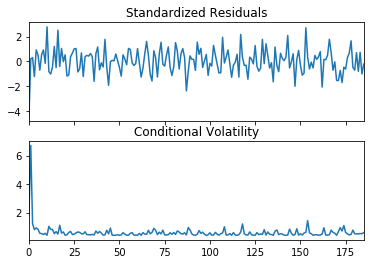

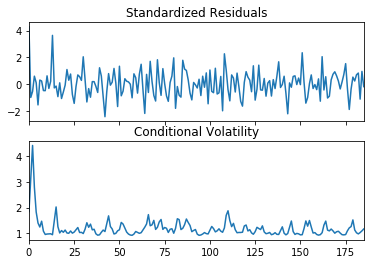

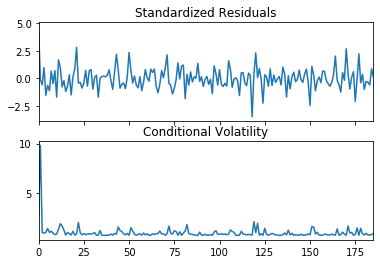

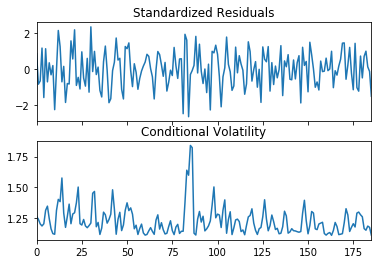

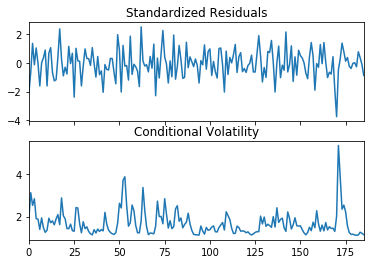

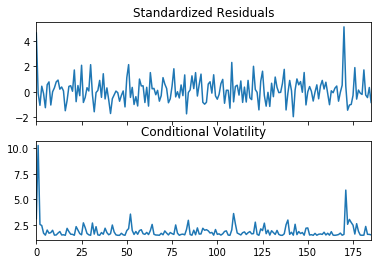

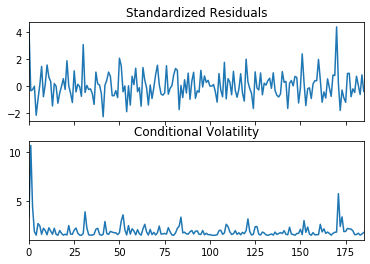

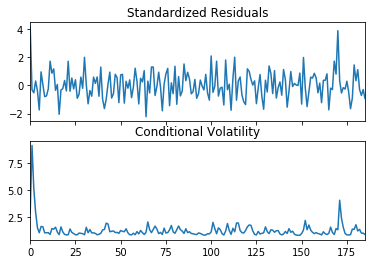

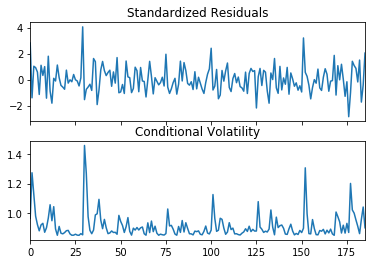

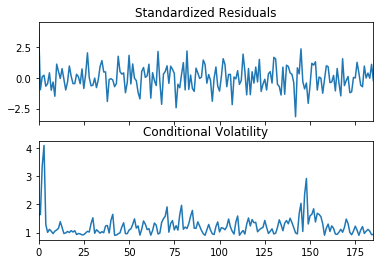

In [27]:
#Check model residuals and conditional volatilities for mean-reversion and trends
fig = resg_USA.plot();
fig = resg_JAP.plot();
fig = resg_NL.plot();
fig = resg_GER.plot();
fig = resg_BR.plot();
fig = resg_HK.plot();
fig = resg_SA.plot();
fig = resg_SK.plot();
fig = resg_AU.plot();
fig = resg_IND.plot();

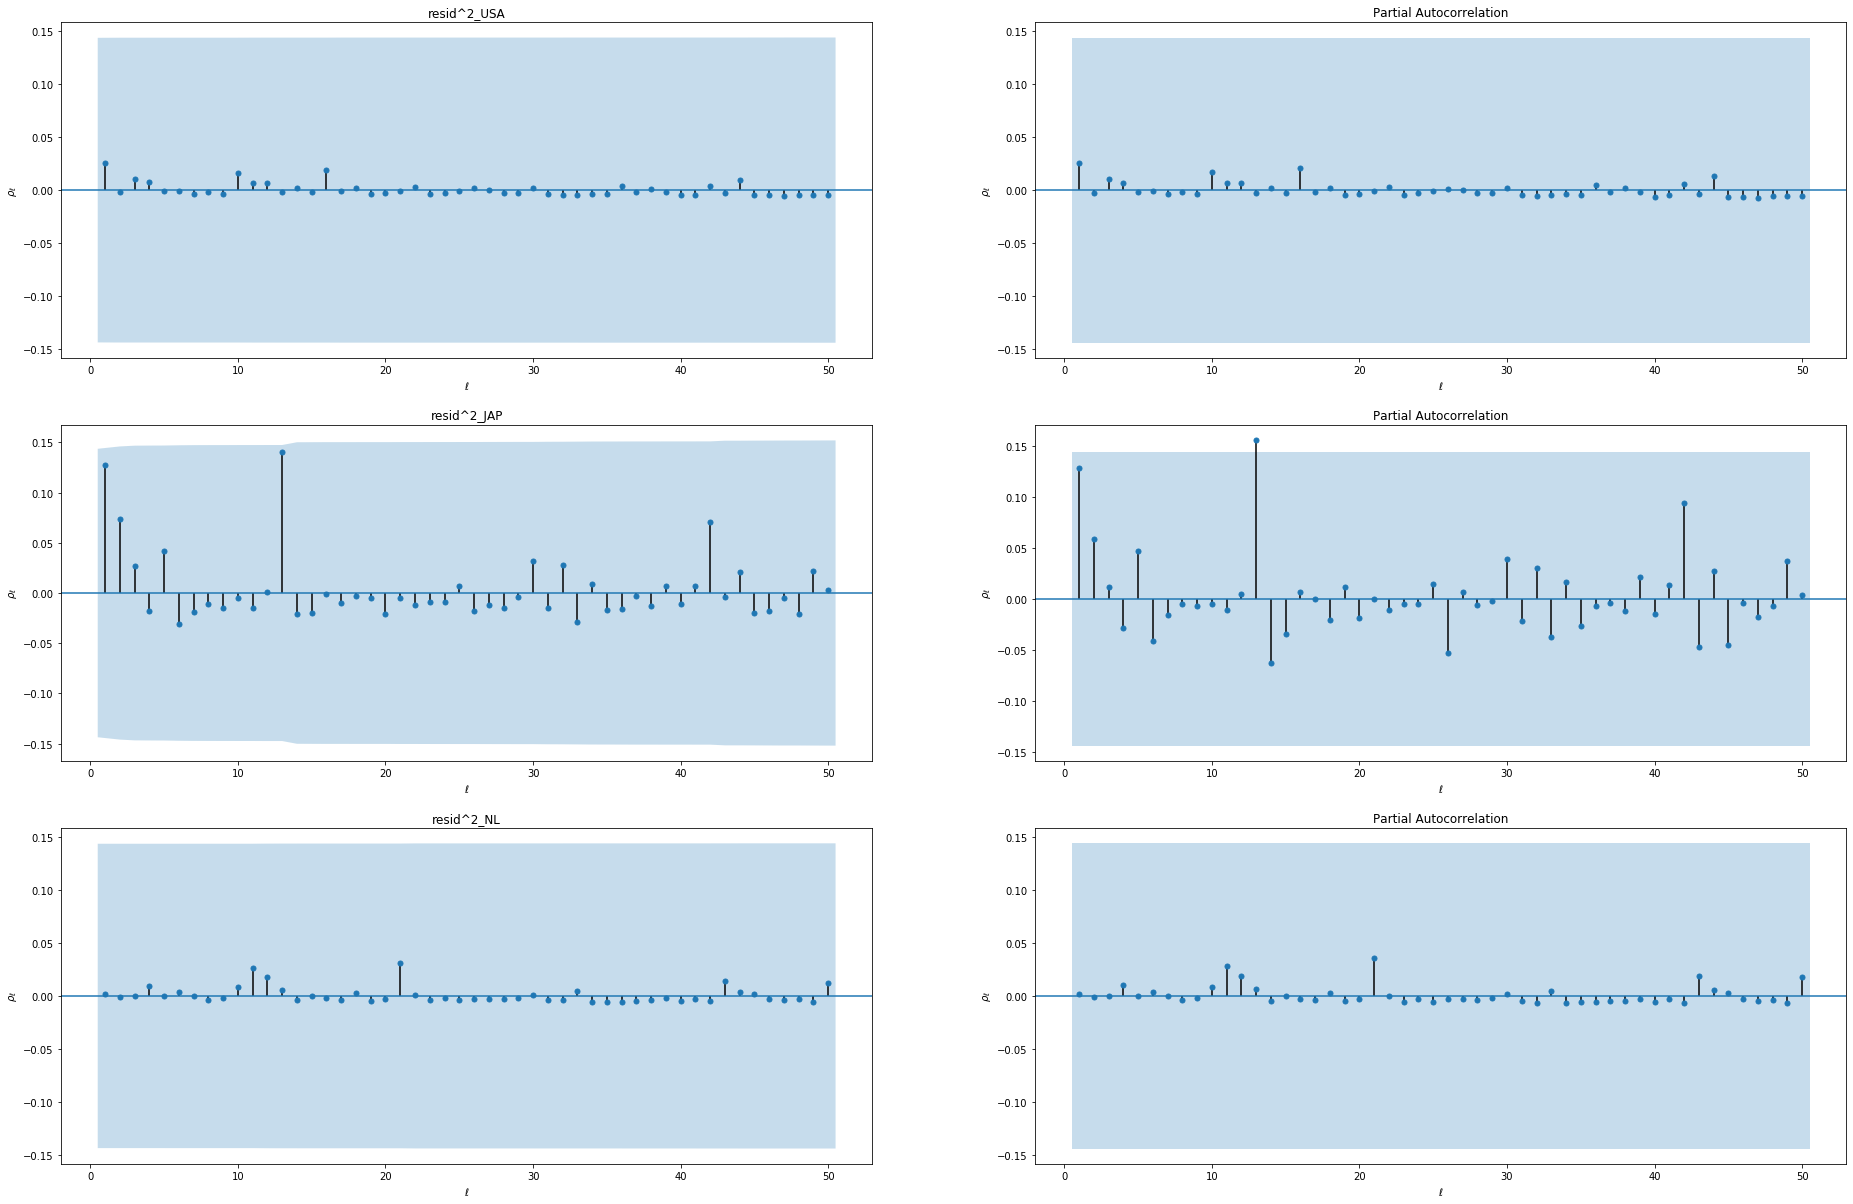

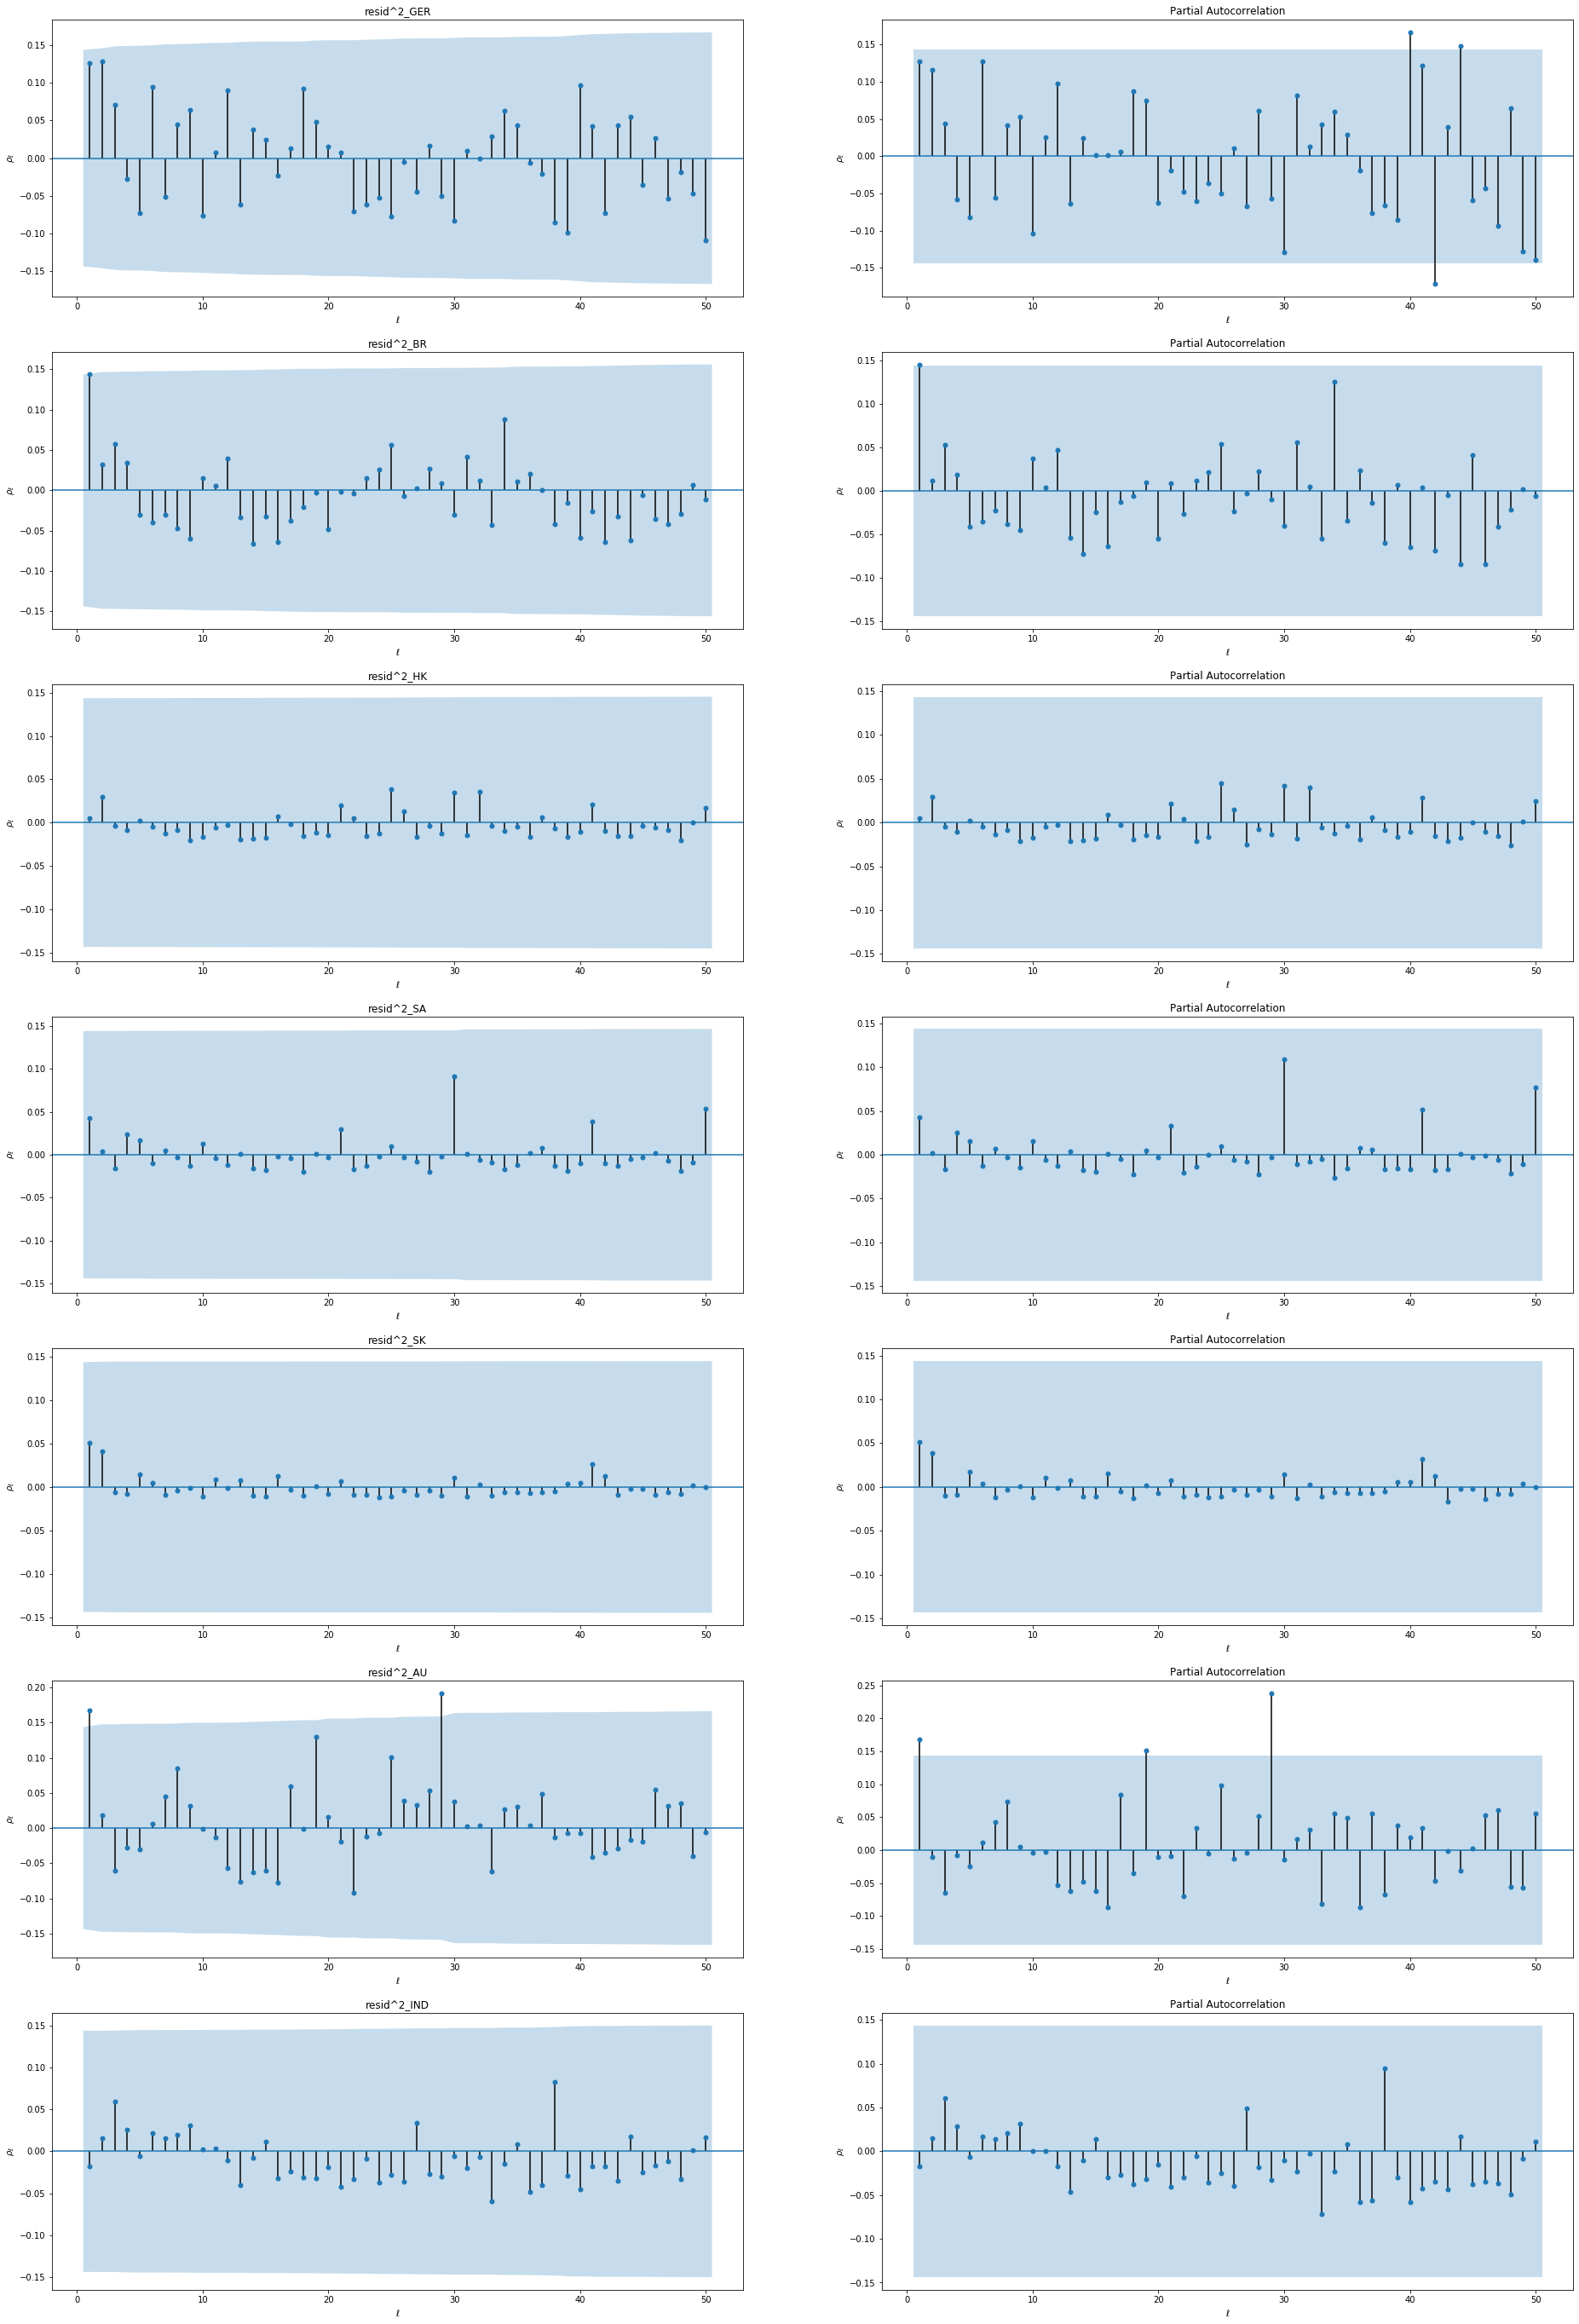

In [250]:
#Print models' correlograms in two figures to make display easier in thesis
fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(32,21));
tsaplots.plot_acf(resg_USA.resid**2, lags=50, zero=False, ax = ax[0][0])
ax[0][0].set_title('resid^2_USA')
ax[0][0].set_ylabel(r'$\rho_\ell$')
ax[0][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_USA.resid**2, lags=50, zero=False, ax = ax[0][1])
ax[0][1].set_ylabel(r'$\rho_\ell$')
ax[0][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_JAP.resid**2, lags=50, zero=False, ax = ax[1][0])
ax[1][0].set_title('resid^2_JAP')
ax[1][0].set_ylabel(r'$\rho_\ell$')
ax[1][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_JAP.resid**2, lags=50, zero=False, ax = ax[1][1])
ax[1][1].set_ylabel(r'$\rho_\ell$')
ax[1][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_NL.resid**2, lags=50, zero=False, ax = ax[2][0])
ax[2][0].set_title('resid^2_NL')
ax[2][0].set_ylabel(r'$\rho_\ell$')
ax[2][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_NL.resid**2, lags=50, zero=False, ax = ax[2][1])
ax[2][1].set_ylabel(r'$\rho_\ell$')
ax[2][1].set_xlabel(r'$\ell$');
tikz_save('correlogramsV1.tikz')

fig,ax = plt.subplots(nrows=7, ncols=2, figsize=(32,49));
tsaplots.plot_acf(resg_GER.resid**2, lags=50, zero=False, ax = ax[0][0])
ax[0][0].set_title('resid^2_GER')
ax[0][0].set_ylabel(r'$\rho_\ell$')
ax[0][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_GER.resid**2, lags=50, zero=False, ax = ax[0][1])
ax[0][1].set_ylabel(r'$\rho_\ell$')
ax[0][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_BR.resid**2, lags=50, zero=False, ax = ax[1][0])
ax[1][0].set_title('resid^2_BR')
ax[1][0].set_ylabel(r'$\rho_\ell$')
ax[1][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_BR.resid**2, lags=50, zero=False, ax = ax[1][1])
ax[1][1].set_ylabel(r'$\rho_\ell$')
ax[1][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_HK.resid**2, lags=50, zero=False, ax = ax[2][0])
ax[2][0].set_title('resid^2_HK')
ax[2][0].set_ylabel(r'$\rho_\ell$')
ax[2][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_HK.resid**2, lags=50, zero=False, ax = ax[2][1])
ax[2][1].set_ylabel(r'$\rho_\ell$')
ax[2][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_SA.resid**2, lags=50, zero=False, ax = ax[3][0])
ax[3][0].set_title('resid^2_SA')
ax[3][0].set_ylabel(r'$\rho_\ell$')
ax[3][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_SA.resid**2, lags=50, zero=False, ax = ax[3][1])
ax[3][1].set_ylabel(r'$\rho_\ell$')
ax[3][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_SK.resid**2, lags=50, zero=False, ax = ax[4][0])
ax[4][0].set_title('resid^2_SK')
ax[4][0].set_ylabel(r'$\rho_\ell$')
ax[4][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_SK.resid**2, lags=50, zero=False, ax = ax[4][1])
ax[4][1].set_ylabel(r'$\rho_\ell$')
ax[4][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_AU.resid**2, lags=50, zero=False, ax = ax[5][0])
ax[5][0].set_title('resid^2_AU')
ax[5][0].set_ylabel(r'$\rho_\ell$')
ax[5][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_AU.resid**2, lags=50, zero=False, ax = ax[5][1])
ax[5][1].set_ylabel(r'$\rho_\ell$')
ax[5][1].set_xlabel(r'$\ell$');
tsaplots.plot_acf(resg_IND.resid**2, lags=50, zero=False, ax = ax[6][0])
ax[6][0].set_title('resid^2_IND')
ax[6][0].set_ylabel(r'$\rho_\ell$')
ax[6][0].set_xlabel(r'$\ell$');
tsaplots.plot_pacf(resg_IND.resid**2, lags=50, zero=False, ax = ax[6][1])
ax[6][1].set_ylabel(r'$\rho_\ell$')
ax[6][1].set_xlabel(r'$\ell$');
tikz_save('correlogramsV2.tikz')

In [29]:
#Test for models' residual autocorrelation (Ljung-Box test)
name = ['LB Test', 'p-value', 'F-version', 'F p-value'];
stand_resid_USA = resg_USA.resid/resg_USA.conditional_volatility;
stand_resid_JAP = resg_JAP.resid/resg_JAP.conditional_volatility;
stand_resid_NL = resg_NL.resid/resg_NL.conditional_volatility;
stand_resid_GER = resg_GER.resid/resg_GER.conditional_volatility;
stand_resid_BR = resg_BR.resid/resg_BR.conditional_volatility;
stand_resid_HK = resg_HK.resid/resg_HK.conditional_volatility;
stand_resid_SA = resg_SA.resid/resg_SA.conditional_volatility;
stand_resid_SK = resg_SK.resid/resg_SK.conditional_volatility;
stand_resid_AU = resg_AU.resid/resg_AU.conditional_volatility;
stand_resid_IND = resg_IND.resid/resg_IND.conditional_volatility;

test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_USA); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_JAP); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_NL); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_GER); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_BR); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_HK); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_SA); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_SK); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_AU); #0lags
print(lzip(name, test));
test = sm.stats.diagnostic.acorr_ljungbox(stand_resid_IND); #0lags
print(lzip(name, test));

[('LB Test', array([ 0.48307726,  5.83871086,  5.9832337 ,  6.62601357,  6.933256  ,
        8.73763089,  8.85873768,  9.73884341, 10.27131254, 11.3864531 ,
       11.50302893, 14.05232705, 14.14732671, 14.31987878, 14.80280517,
       15.47862979, 18.54465986, 18.9130999 , 20.06613915, 22.06587227,
       22.99195774, 24.20049321, 24.42377391, 27.69366561, 27.69904105,
       29.51299972, 29.5269538 , 29.54404443, 29.83213615, 30.08600965,
       32.80012018, 32.81890748, 32.93630876, 33.05330457, 33.43162557,
       37.3375846 , 38.57389573, 39.16732257, 39.27929624, 39.53323754])), ('p-value', array([0.48703174, 0.05396846, 0.1124288 , 0.15702166, 0.22565166,
       0.18888004, 0.2629579 , 0.28383625, 0.32897083, 0.32821264,
       0.40213237, 0.29737926, 0.36355095, 0.42616192, 0.46571267,
       0.48990139, 0.35528511, 0.39719305, 0.39060821, 0.33694696,
       0.34440736, 0.33680835, 0.38066246, 0.27317237, 0.32189284,
       0.28827552, 0.33582202, 0.38533748, 0.4224189 , 0.4612

[('JB Test Statistic:', 25.00874382266837), ('p-value:', 3.7103961378903705e-06)]
[('JB Test Statistic:', 33.47710066241015), ('p-value:', 5.376999001605043e-08)]
[('JB Test Statistic:', 76.17781168451243), ('p-value:', 0.0)]
[('JB Test Statistic:', 1.7850628445777483), ('p-value:', 0.40961752427854614)]
[('JB Test Statistic:', 3.206209777169477), ('p-value:', 0.2012706239690618)]
[('JB Test Statistic:', 208.92855205583817), ('p-value:', 0.0)]
[('JB Test Statistic:', 96.17370701106991), ('p-value:', 0.0)]
[('JB Test Statistic:', 30.584776461639763), ('p-value:', 2.283495584842754e-07)]
[('JB Test Statistic:', 21.694655147195313), ('p-value:', 1.9456534630646338e-05)]
[('JB Test Statistic:', 13.893013421710421), ('p-value:', 0.0009619897994326276)]


Text(0.5, 1.0, 'Student-t Fit')

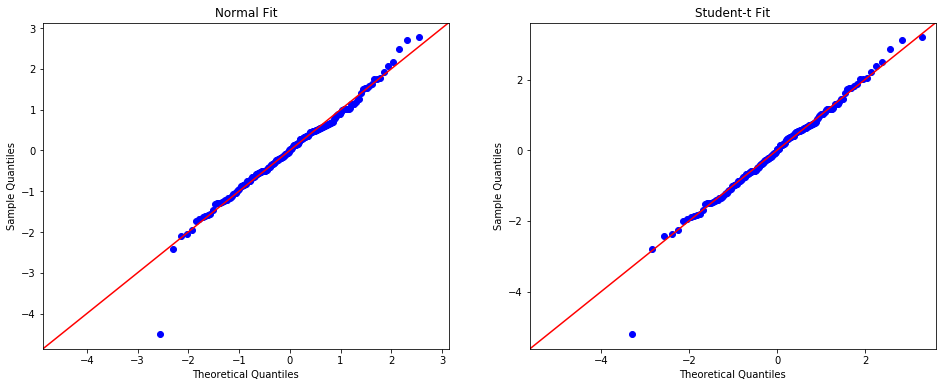

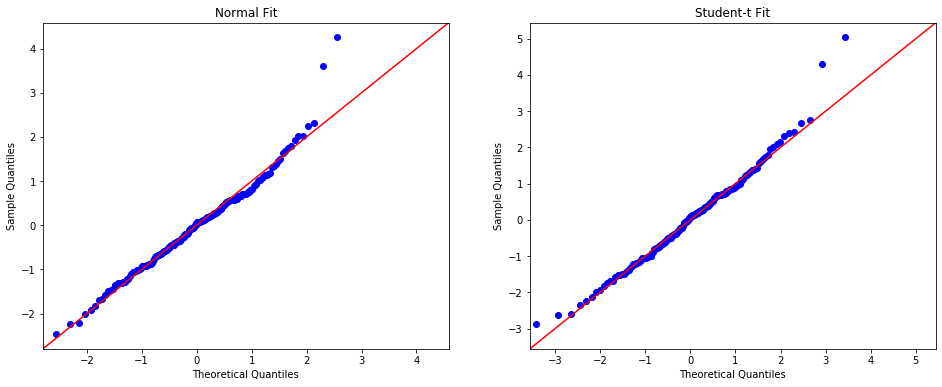

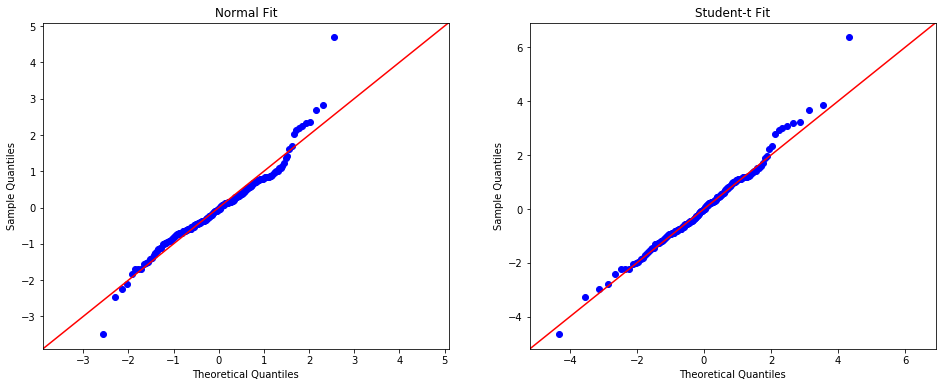

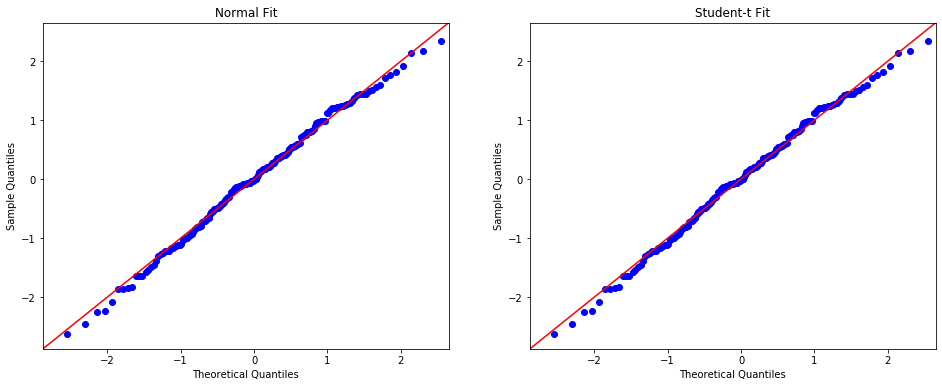

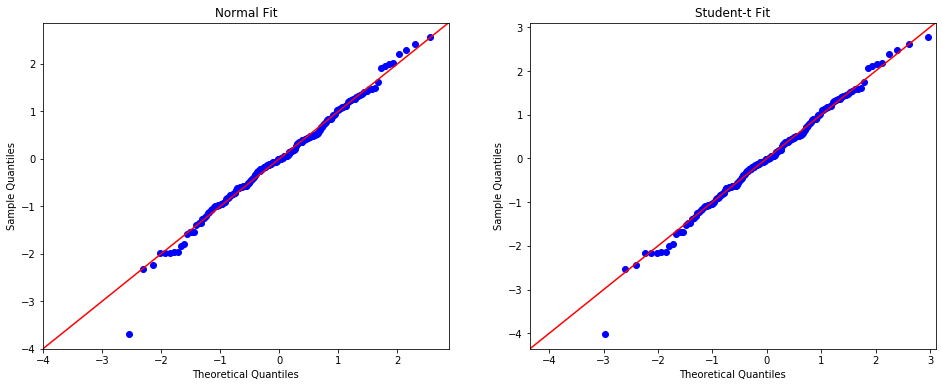

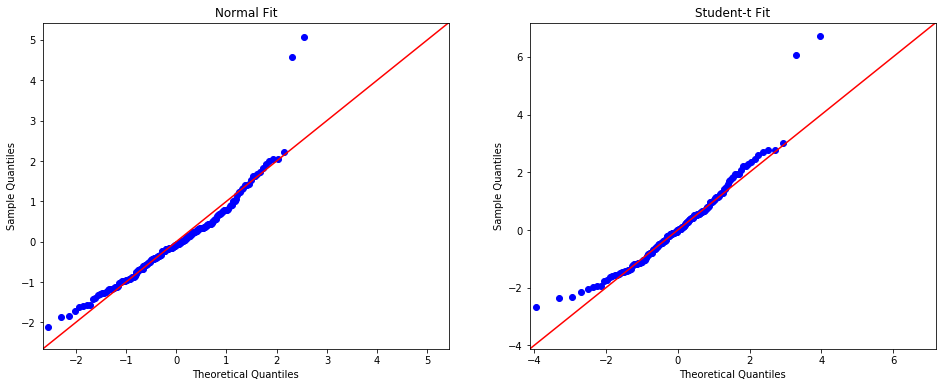

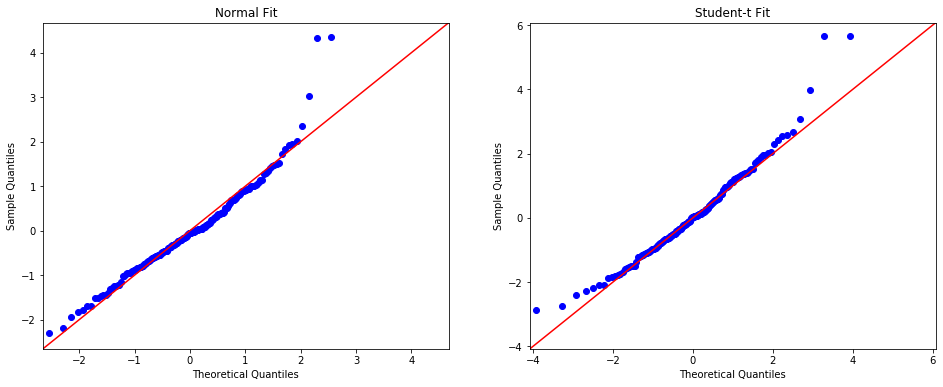

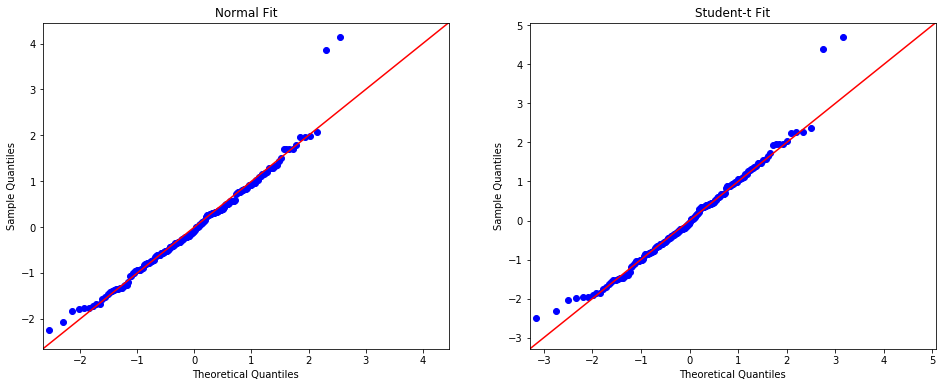

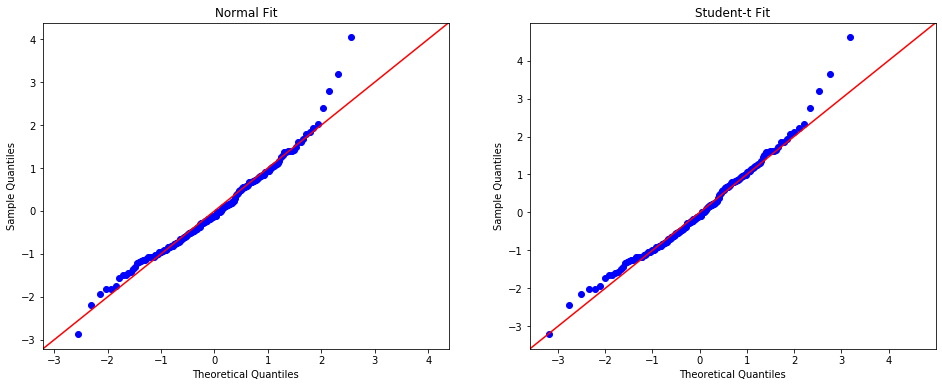

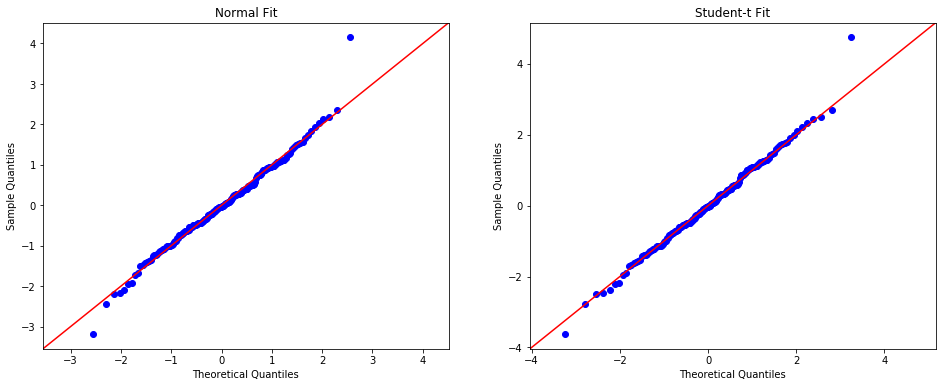

In [31]:
#Use the Jarque-Bera test to test for normal distributions in comparison to t-distributions

stand_resid_USA = resg_USA.resid/resg_USA.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_USA);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_USA, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_USA, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_JAP = resg_JAP.resid/resg_JAP.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_JAP);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_JAP, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_JAP, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_NL = resg_NL.resid/resg_NL.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_NL);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_NL, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_NL, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_GER = resg_GER.resid/resg_GER.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_GER);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_GER, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_GER, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_BR = resg_BR.resid/resg_BR.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_BR);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_BR, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_BR, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_HK = resg_HK.resid/resg_HK.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_HK);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_HK, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_HK, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_SA = resg_SA.resid/resg_SA.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_SA);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_SA, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_SA, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_SK = resg_SK.resid/resg_SK.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_SK);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_SK, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_SK, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_AU = resg_AU.resid/resg_AU.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_AU);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_AU, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_AU, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

stand_resid_IND = resg_IND.resid/resg_IND.conditional_volatility;
keys = ['JB Test Statistic:', 'p-value:', 'Skew:', 'Kurtosis:'];
results = stats.jarque_bera(stand_resid_IND);
print(lzip(keys, results));
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6));
sm.qqplot(stand_resid_IND, dist=stats.norm,fit=True,line='45', ax = ax[0]);
ax[0].set_title('Normal Fit')
sm.qqplot(stand_resid_IND, dist=stats.t,fit=True,line='45', ax = ax[1]);
ax[1].set_title('Student-t Fit')

In [219]:
#Import relevant R packages

# import rpy2's package module
import rpy2.robjects.packages as rpackages
from rpy2.robjects.packages import importr
from rpy2.robjects import r

utils = rpackages.importr('utils')
base = rpackages.importr('base')
methods = rpackages.importr('methods')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

rmgarch=rpackages.importr('rmgarch', lib_loc='C:/Users/shuva/Documents/R/win-library/3.6')
mgarchBEKK=rpackages.importr('mgarchBEKK', lib_loc='C:/Users/shuva/Documents/R/win-library/3.6')
rugarch=rpackages.importr('rugarch', lib_loc='C:/Users/shuva/Documents/R/win-library/3.6')
reticulate=rpackages.importr('reticulate', lib_loc='C:/Users/shuva/Documents/R/win-library/3.6')

In [220]:
#Load appropriate packages to use r-code
from rpy2 import robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [221]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [222]:
#Transform existing the existing training time-series into r-objects
lr_USA = pandas2ri.py2ri(df_tr2.log_ret_USA)   
lr_USA = robjects.r.matrix(lr_USA, nrow=len(lr_USA))  
lr_JAP = pandas2ri.py2ri(df_tr2.log_ret_JAP)
lr_JAP = robjects.r.matrix(lr_JAP, nrow=len(lr_JAP))
lr_NL = pandas2ri.py2ri(df_tr2.log_ret_NL)
lr_NL = robjects.r.matrix(lr_NL, nrow=len(lr_NL))
lr_GER = pandas2ri.py2ri(df_tr2.log_ret_GER)
lr_GER = robjects.r.matrix(lr_GER, nrow=len(lr_GER))
lr_BR = pandas2ri.py2ri(df_tr2.log_ret_BR)
lr_BR = robjects.r.matrix(lr_BR, nrow=len(lr_BR))
lr_HK = pandas2ri.py2ri(df_tr2.log_ret_HK)
lr_HK = robjects.r.matrix(lr_HK, nrow=len(lr_HK))
lr_SA = pandas2ri.py2ri(df_tr2.log_ret_SA)
lr_SA = robjects.r.matrix(lr_SA, nrow=len(lr_SA))
lr_SK = pandas2ri.py2ri(df_tr2.log_ret_SK)
lr_SK = robjects.r.matrix(lr_SK, nrow=len(lr_SK))
lr_AU = pandas2ri.py2ri(df_tr2.log_ret_AU)
lr_AU = robjects.r.matrix(lr_AU, nrow=len(lr_AU))
lr_IND = pandas2ri.py2ri(df_tr2.log_ret_IND)
lr_IND = robjects.r.matrix(lr_IND, nrow=len(lr_IND))
mkt_tr2 = pandas2ri.py2ri(mkt_tr)
mkt_tr2 = robjects.r.matrix(mkt_tr2, nrow=len(mkt_tr2))
mkt_test2 = pandas2ri.py2ri(mkt_test)
mkt_test2 = robjects.r.matrix(mkt_test2, nrow=len(mkt_test2))

In [223]:
#Combine training r-objects into dataframe
%%R -i lr_USA,lr_JAP,lr_NL,lr_GER,lr_BR,lr_HK,lr_SA,lr_SK,lr_AU,lr_IND -o df1

library(base)

df1 = cbind(lr_USA, lr_JAP, lr_NL, lr_GER, lr_BR, lr_HK, lr_SA, lr_SK, lr_AU, lr_IND)
colnames(df1) = c('USA', 'JAP', 'NL', 'GER', 'BR', 'HK', 'SA', 'SK', 'AU', 'IND')

In [224]:
#Transform the entire exiting time-series (training and test subsets together) into r-objects
lr_USA = pandas2ri.py2ri(df2.log_ret_USA)   
lr_USA = robjects.r.matrix(lr_USA, nrow=len(lr_USA))
lr_JAP = pandas2ri.py2ri(df2.log_ret_JAP)
lr_JAP = robjects.r.matrix(lr_JAP, nrow=len(lr_JAP))
lr_NL = pandas2ri.py2ri(df2.log_ret_NL)
lr_NL = robjects.r.matrix(lr_NL, nrow=len(lr_NL))
lr_GER = pandas2ri.py2ri(df2.log_ret_GER)
lr_GER = robjects.r.matrix(lr_GER, nrow=len(lr_GER))
lr_BR = pandas2ri.py2ri(df2.log_ret_BR)
lr_BR = robjects.r.matrix(lr_BR, nrow=len(lr_BR))
lr_HK = pandas2ri.py2ri(df2.log_ret_HK)
lr_HK = robjects.r.matrix(lr_HK, nrow=len(lr_HK))
lr_SA = pandas2ri.py2ri(df2.log_ret_SA)
lr_SA = robjects.r.matrix(lr_SA, nrow=len(lr_SA))
lr_SK = pandas2ri.py2ri(df2.log_ret_SK)
lr_SK = robjects.r.matrix(lr_SK, nrow=len(lr_SK))
lr_AU = pandas2ri.py2ri(df2.log_ret_AU)
lr_AU = robjects.r.matrix(lr_AU, nrow=len(lr_AU))
lr_IND = pandas2ri.py2ri(df2.log_ret_IND)
lr_IND = robjects.r.matrix(lr_IND, nrow=len(lr_IND))

mkt2 = pandas2ri.py2ri(mkt2)
mkt2 = robjects.r.matrix(mkt2, nrow=len(mkt2))

In [225]:
#Combine entire dataset's robjects into dataframe
%%R -i lr_USA,lr_JAP,lr_NL,lr_GER,lr_BR,lr_HK,lr_SA,lr_SK,lr_AU,lr_IND -o df2

library(base)

df2 = cbind(lr_USA, lr_JAP, lr_NL, lr_GER, lr_BR, lr_HK, lr_SA, lr_SK, lr_AU, lr_IND)
colnames(df2) = c('USA', 'JAP', 'NL', 'GER', 'BR', 'HK', 'SA', 'SK', 'AU', 'IND')

In [226]:
#Fit appropriate VARX model using r-code
V = rmgarch.varxfit(df1, p = 5, constant = "TRUE", exogen=mkt_tr2)
print(V)

$Bcoef

        USA.l1      JAP.l1        NL.l1      GER.l1        BR.l1       HK.l1

USA -0.6592487  0.12835401  0.228877269  0.01300841  0.076911608  0.21418246

JAP  1.0862716 -1.41895919  0.030973979  0.15364914  0.087908697 -0.16240008

NL   0.8149290  0.06014372 -1.286973105 -0.11119582 -0.031532578  0.01490461

GER  0.8860097  0.16975078  0.201924882 -1.49587517 -0.041712555  0.02453837

BR   0.5261154  0.44611200  0.039270303  0.14855774 -1.105705851 -0.10575642

HK   0.9052179  0.08181281  0.001194561  0.25742541 -0.082864800 -1.33703821

SA   0.7634866  0.06191755 -0.176775724  0.07567350 -0.042389984  0.14393419

SK   0.7163817  0.03239291 -0.223807145  0.19570569 -0.001283979 -0.03369801

AU   0.4173414  0.07758239  0.372159061  0.04120431 -0.038241088 -0.14910387

IND  0.3220793  0.14269993 -0.061227611  0.12051682 -0.005026335  0.01810360

           SA.l1       SK.l1        AU.l1       IND.l1     USA.l2      JAP.l2

USA  0.006096568 -0.06472507  0.008025044  0.019801364 

In [227]:
#Define the appropriate garch models (and arma models with 0 lags as the VARX model will replace them)
armaorder = robjects.r.matrix(robjects.FloatVector([0,0]), nrow=1)  # a 1x2 R matrix
zeromean = robjects.ListVector({'armaOrder': armaorder, 'include.mean': False})  # a list() with input-value pairs
garchorder = robjects.r.matrix(robjects.FloatVector([3,0]), nrow=1)  # a 1x2 R matrix
garch = robjects.ListVector({'model': 'sGARCH', 'garchOrder': garchorder})  # a list() with input-value pairs
garchspec_t = rugarch.ugarchspec(mean_model = zeromean, variance_model = garch, distribution_model = "std")
garchspec_norm = rugarch.ugarchspec(mean_model = zeromean, variance_model = garch, distribution_model = "norm")
print(garchspec_t, garchspec_norm)



*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*



Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(3,0)

Variance Targeting	: FALSE 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(0,0,0)

Include Mean		: FALSE 

GARCH-in-Mean		: FALSE 



Conditional Distribution

------------------------------------

Distribution	:  std 

Includes Skew	:  FALSE 

Includes Shape	:  TRUE 

Includes Lambda	:  FALSE 


 

*---------------------------------*

*       GARCH Model Spec          *

*---------------------------------*



Conditional Variance Dynamics 	

------------------------------------

GARCH Model		: sGARCH(3,0)

Variance Targeting	: FALSE 



Conditional Mean Dynamics

------------------------------------

Mean Model		: ARFIMA(0,0,0)

Include Mean		: FALSE 

GARCH-in-Mean		: FALSE 



Conditional Distribution

-----------------------------

In [228]:
#Define sequence of combining previously specified garch models into one multivariate model
uspec = rugarch.multispec([garchspec_t, garchspec_t, garchspec_t, garchspec_norm, garchspec_norm, garchspec_t, garchspec_t, garchspec_t, garchspec_t, garchspec_t])

#Define and fit DCC model
dcc_spec = rmgarch.dccspec(uspec, VAR = 'TRUE', lag=5, model='DCC', distribution = 'mvnorm', external_regressors=mkt2)
fitcontrol = robjects.ListVector({'eval.se': 'TRUE'})
dcc_fit = rmgarch.dccfit(dcc_spec, data=df2, VAR_fit = V, fit_control = fitcontrol, out_sample = 68)
print(methods.show(dcc_fit))



*---------------------------------*

*          DCC GARCH Fit          *

*---------------------------------*



Distribution         :  mvnorm

Model                :  DCC(1,1)

No. Parameters       :  615

[VAR GARCH DCC UncQ] : [520+48+2+45]

No. Series           :  10

No. Obs.             :  181

Log-Likelihood       :  -2335.367

Av.Log-Likelihood    :  -12.9 



Optimal Parameters

-----------------------------------

              Estimate  Std. Error  t value Pr(>|t|)

[USA].omega   0.165418    0.028535 5.797112 0.000000

[USA].alpha1  0.000851    0.069249 0.012286 0.990197

[USA].alpha2  0.002802    0.060762 0.046119 0.963215

[USA].alpha3  0.030606    0.054552 0.561041 0.574770

[USA].shape   3.853273    0.743150 5.185057 0.000000

[JAP].omega   0.858214    0.232463 3.691837 0.000223

[JAP].alpha1  0.054346    0.083224 0.653013 0.513748

[JAP].alpha2  0.000000    0.304446 0.000000 1.000000

[JAP].alpha3  0.064388    0.160466 0.401257 0.688231

[JAP].shape   4.036401    0.8

In [229]:
#Create and save forecasts using fitted DCC model
exog = robjects.ListVector({'mregfor': mkt_test2})
dcc_fore = rmgarch.dccforecast(dcc_fit, n_ahead = 1, n_roll = 61, external_forecasts = exog)
print(methods.show(dcc_fore))



*---------------------------------*

*       DCC GARCH Forecast        *

*---------------------------------*



Distribution         :  mvnorm

Model                :  DCC(1,1)

Horizon              :  1

Roll Steps           :  61

-----------------------------------



0-roll forecast: 

, , 1



           [,1]     [,2]      [,3]      [,4]      [,5]     [,6]    [,7]

 [1,]  1.000000 -0.49792 -0.530817  0.008196  0.016963 -0.60430 -0.6190

 [2,] -0.497916  1.00000  0.288900 -0.132369 -0.055680  0.48961  0.3037

 [3,] -0.530817  0.28890  1.000000  0.096028  0.004709  0.44135  0.6252

 [4,]  0.008196 -0.13237  0.096028  1.000000  0.106345  0.03898  0.1191

 [5,]  0.016963 -0.05568  0.004709  0.106345  1.000000 -0.31974 -0.1108

 [6,] -0.604301  0.48961  0.441353  0.038977 -0.319741  1.00000  0.5479

 [7,] -0.618996  0.30370  0.625151  0.119133 -0.110775  0.54787  1.0000

 [8,] -0.526040  0.67459  0.376865  0.067330 -0.181878  0.66766  0.4219

 [9,] -0.239331  0.43975  0.246771 -0.18

In [230]:
#Deine appropriate GO-GARCH model
mean = robjects.ListVector({'model': 'VAR', 'lag':'5', 'external.regressors':mkt2})
variance = robjects.ListVector({'model': 'sGARCH', 'garchOrder': garchorder})

#Fit GOGARCH model
gogarch_spec = rmgarch.gogarchspec(mean_model = mean, variance_model = variance, distribution_model = 'mvnorm')
fitcontrol = robjects.ListVector({'stationarity': 'TRUE'})
gogarch_fit = rmgarch.gogarchfit(gogarch_spec, data=df2, VAR_fit = V, fit_control = fitcontrol, out_sample = 68, solver = 'solnp')

#Utilize fitted GOGARCH model to create forecasts over test-period
exog = robjects.ListVector({'mregfor': mkt_test2})
gogarch_fore = rmgarch.gogarchforecast(gogarch_fit, n_ahead = 1, n_roll = 61, external_forecasts = exog)
print(gogarch_fit.slots["mfit"])

$factor.sigmas

            [,1]      [,2]      [,3]      [,4]      [,5]      [,6]      [,7]

  [1,] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000

  [2,] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000

  [3,] 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000

  [4,] 1.1918619 0.8479317 0.8848618 2.1000550 0.9344011 0.9361136 1.0082517

  [5,] 1.4280210 0.9863494 0.9000899 1.3924287 0.9162111 0.9958149 0.4985667

  [6,] 6.8313777 0.8364527 0.8860375 0.9609492 0.9327195 0.9361333 0.5093960

  [7,] 1.7256305 1.0182162 0.8893746 0.8959542 0.9183610 0.9445680 0.4929175

  [8,] 2.0644088 0.8384115 0.8895574 0.7619953 1.1539539 0.9535353 0.4807427

  [9,] 0.9114078 0.9100836 0.9916521 0.7937718 0.9176079 0.9405722 0.4708050

 [10,] 0.7722765 0.9784479 0.9807268 0.7708431 0.9161465 0.9427615 0.5412827

 [11,] 0.7101127 0.8290439 1.1601641 0.7792931 0.9221734 0.9384048 0.4905886

 [12,] 0.8618924 1.2299688 0.8898028 0.8377953 0

In [231]:
#Create dataset without VARX's lag variables
df_outsample = df_tr2.iloc[5:]
print(df_outsample.shape)

(181, 10)


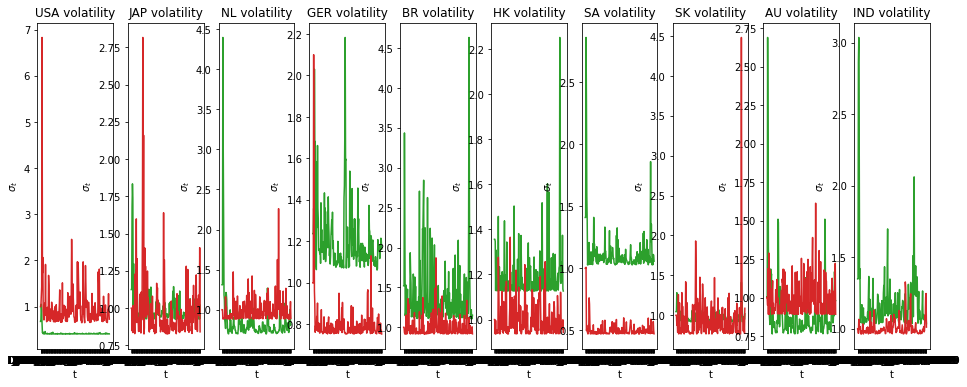

In [232]:
#Compare the volatilities of both models
s_dcc = pandas2ri.ri2py(rugarch.sigma(dcc_fit))  
s_dcc = pd.DataFrame(s_dcc, index=df_outsample.index, columns=['USA', 'JAP', 'NL', 'GER', 'BR', 'HK', 'SA', 'SK', 'AU', 'IND'])  # Convert to pandas DataFrame

s_gogarch = pandas2ri.ri2py(rugarch.sigma(gogarch_fit))  
s_gogarch = pd.DataFrame(s_gogarch, index=df_outsample.index, columns=['USA', 'JAP', 'NL', 'GER', 'BR', 'HK', 'SA', 'SK', 'AU', 'IND'])  # Convert to pandas DataFrame

#Plot values
fig,ax = plt.subplots(nrows=1, ncols=10, figsize=(16,6));
ax[0].plot(s_dcc.USA.iloc[1:], 'tab:green')
ax[0].plot(s_gogarch.USA.iloc[1:], 'tab:red')
ax[0].set_title('USA volatility')
ax[0].set_ylabel(r'$\sigma_{t}$')
ax[0].set_xlabel('t');
ax[1].plot(s_dcc.JAP.iloc[1:], 'tab:green')
ax[1].plot(s_gogarch.JAP.iloc[1:], 'tab:red')
ax[1].set_title('JAP volatility')
ax[1].set_ylabel(r'$\sigma_{t}$')
ax[1].set_xlabel('t');
ax[2].plot(s_dcc.NL.iloc[1:], 'tab:green')
ax[2].plot(s_gogarch.NL.iloc[1:], 'tab:red')
ax[2].set_title('NL volatility')
ax[2].set_ylabel(r'$\sigma_{t}$')
ax[2].set_xlabel('t');
ax[3].plot(s_dcc.GER.iloc[1:], 'tab:green')
ax[3].plot(s_gogarch.GER.iloc[1:], 'tab:red')
ax[3].set_title('GER volatility')
ax[3].set_ylabel(r'$\sigma_{t}$')
ax[3].set_xlabel('t');
ax[4].plot(s_dcc.BR.iloc[1:], 'tab:green')
ax[4].plot(s_gogarch.BR.iloc[1:], 'tab:red')
ax[4].set_title('BR volatility')
ax[4].set_ylabel(r'$\sigma_{t}$')
ax[4].set_xlabel('t');
ax[5].plot(s_dcc.HK.iloc[1:], 'tab:green')
ax[5].plot(s_gogarch.HK.iloc[1:], 'tab:red')
ax[5].set_title('HK volatility')
ax[5].set_ylabel(r'$\sigma_{t}$')
ax[5].set_xlabel('t');
ax[6].plot(s_dcc.SA.iloc[1:], 'tab:green')
ax[6].plot(s_gogarch.SA.iloc[1:], 'tab:red')
ax[6].set_title('SA volatility')
ax[6].set_ylabel(r'$\sigma_{t}$')
ax[6].set_xlabel('t');
ax[7].plot(s_dcc.SK.iloc[1:], 'tab:green')
ax[7].plot(s_gogarch.SK.iloc[1:], 'tab:red')
ax[7].set_title('SK volatility')
ax[7].set_ylabel(r'$\sigma_{t}$')
ax[7].set_xlabel('t');
ax[8].plot(s_dcc.AU.iloc[1:], 'tab:green')
ax[8].plot(s_gogarch.AU.iloc[1:], 'tab:red')
ax[8].set_title('AU volatility')
ax[8].set_ylabel(r'$\sigma_{t}$')
ax[8].set_xlabel('t');
ax[9].plot(s_dcc.IND.iloc[1:], 'tab:green')
ax[9].plot(s_gogarch.IND.iloc[1:], 'tab:red')
ax[9].set_title('IND volatility')
ax[9].set_ylabel(r'$\sigma_{t}$')
ax[9].set_xlabel('t');

In [233]:
#Get actual correlations for stock indices over test-period
df_test_corr = pd.DataFrame(df_test2).copy()

for i in range(0,df_test_corr.shape[0]-9):
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_JAP'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_JAP[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_NL'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_NL[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_GER'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_GER[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_BR'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_BR[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_HK'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_HK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_SA'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_SA[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_SK'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_SK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_AU'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_USA_IND'], _ = pearsonr(df_test2.log_ret_USA[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_NL'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_NL[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_GER'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_GER[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_BR'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_BR[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_HK'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_HK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_SA'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_SA[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_SK'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_SK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_AU'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_JAP_IND'], _ = pearsonr(df_test2.log_ret_JAP[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_NL_GER'], _ = pearsonr(df_test2.log_ret_NL[i:i+9],df_test2.log_ret_GER[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_NL_BR'], _ = pearsonr(df_test2.log_ret_NL[i:i+9],df_test2.log_ret_BR[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_NL_HK'], _ = pearsonr(df_test2.log_ret_NL[i:i+9],df_test2.log_ret_HK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_NL_SA'], _ = pearsonr(df_test2.log_ret_NL[i:i+9],df_test2.log_ret_SA[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_NL_SK'], _ = pearsonr(df_test2.log_ret_NL[i:i+9],df_test2.log_ret_SK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_NL_AU'], _ = pearsonr(df_test2.log_ret_NL[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_NL_IND'], _ = pearsonr(df_test2.log_ret_NL[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_GER_BR'], _ = pearsonr(df_test2.log_ret_GER[i:i+9],df_test2.log_ret_BR[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_GER_HK'], _ = pearsonr(df_test2.log_ret_GER[i:i+9],df_test2.log_ret_HK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_GER_SA'], _ = pearsonr(df_test2.log_ret_GER[i:i+9],df_test2.log_ret_SA[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_GER_SK'], _ = pearsonr(df_test2.log_ret_GER[i:i+9],df_test2.log_ret_SK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_GER_AU'], _ = pearsonr(df_test2.log_ret_GER[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_GER_IND'], _ = pearsonr(df_test2.log_ret_GER[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_BR_HK'], _ = pearsonr(df_test2.log_ret_BR[i:i+9],df_test2.log_ret_HK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_BR_SA'], _ = pearsonr(df_test2.log_ret_BR[i:i+9],df_test2.log_ret_SA[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_BR_SK'], _ = pearsonr(df_test2.log_ret_BR[i:i+9],df_test2.log_ret_SK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_BR_AU'], _ = pearsonr(df_test2.log_ret_BR[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_BR_IND'], _ = pearsonr(df_test2.log_ret_BR[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_HK_SA'], _ = pearsonr(df_test2.log_ret_HK[i:i+9],df_test2.log_ret_SA[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_HK_SK'], _ = pearsonr(df_test2.log_ret_HK[i:i+9],df_test2.log_ret_SK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_HK_AU'], _ = pearsonr(df_test2.log_ret_HK[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_HK_IND'], _ = pearsonr(df_test2.log_ret_HK[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_SA_SK'], _ = pearsonr(df_test2.log_ret_SA[i:i+9],df_test2.log_ret_SK[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_SA_AU'], _ = pearsonr(df_test2.log_ret_SA[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_SA_IND'], _ = pearsonr(df_test2.log_ret_SA[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_SK_AU'], _ = pearsonr(df_test2.log_ret_SK[i:i+9],df_test2.log_ret_AU[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_SK_IND'], _ = pearsonr(df_test2.log_ret_SK[i:i+9],df_test2.log_ret_IND[i:i+9])
    df_test_corr.loc[df_test2.index[i+9],'Corr_AU_IND'], _ = pearsonr(df_test2.log_ret_AU[i:i+9],df_test2.log_ret_IND[i:i+9])
    
df_test_corr = df_test_corr.iloc[:,10:]
print(df_test2)

              log_ret_USA  log_ret_JAP  log_ret_NL  log_ret_GER  log_ret_BR  \
Date                                                                          
Dec 19, 2019     1.277176     0.985183    0.575583     0.815534   -2.238220   
Dec 20, 2019    -0.439855    -0.168686    0.632234     0.811077    0.066150   
Dec 23, 2019    -0.455004     0.132175   -1.200069    -1.290567    1.371125   
Dec 27, 2019     0.815464    -0.170149    0.881009     0.714414   -0.716166   
Dec 30, 2019    -1.483899    -0.883244   -1.444749    -2.519776   -1.002780   
Jan 06, 2020     2.427659    -0.333160    2.228637     4.781443    2.343203   
Jan 07, 2020    -2.406041     4.679190   -0.910378    -3.944768   -2.245478   
Jan 08, 2020     1.823264    -6.685259   -0.453211     2.537579    0.798681   
Jan 09, 2020    -0.595491     7.037410    0.492038    -1.678874    0.269342   
Jan 10, 2020    -1.123522    -5.680464   -0.897501    -0.079444   -0.223222   
Jan 14, 2020     1.778805     2.078785    1.149778  

In [ ]:
#Separate forecasted correlations for only those involving USA
rho_dcc = pandas2ri.ri2py(rmgarch.rcor(dcc_fore))
rho_dcc = np.concatenate(rho_dcc,axis=2)
rho_dcc_usa_jap = rho_dcc[0,1,:]
rho_dcc_usa_jap = pd.Series(rho_dcc_usa_jap, index=df_test_corr.index, name='Corr_USA_JAP')

rho_gogarch = pandas2ri.ri2py(rmgarch.rcor(gogarch_fore))
rho_gogarch = np.concatenate(rho_gogarch,axis=2)
rho_gogarch_usa_jap = rho_gogarch[0,1,:]
rho_gogarch_usa_jap = pd.Series(rho_gogarch_usa_jap, index=df_test_corr.index, name='Corr_USA_JAP')

rho_dcc_usa_nl = rho_dcc[0,2,:]
rho_dcc_usa_nl = pd.Series(rho_dcc_usa_nl, index=df_test_corr.index, name='Corr_USA_NL')

rho_gogarch_usa_nl = rho_gogarch[0,2,:]
rho_gogarch_usa_nl = pd.Series(rho_gogarch_usa_nl, index=df_test_corr.index, name='Corr_USA_NL')

rho_dcc_usa_ger = rho_dcc[0,3,:]
rho_dcc_usa_ger = pd.Series(rho_dcc_usa_ger, index=df_test_corr.index, name='Corr_USA_GER')

rho_gogarch_usa_ger = rho_gogarch[0,3,:]
rho_gogarch_usa_ger = pd.Series(rho_gogarch_usa_ger, index=df_test_corr.index, name='Corr_USA_GER')

rho_dcc_usa_br = rho_dcc[0,4,:]
rho_dcc_usa_br = pd.Series(rho_dcc_usa_br, index=df_test_corr.index, name='Corr_USA_BR')

rho_gogarch_usa_br = rho_gogarch[0,4,:]
rho_gogarch_usa_br = pd.Series(rho_gogarch_usa_br, index=df_test_corr.index, name='Corr_USA_BR')

rho_dcc_usa_hk = rho_dcc[0,5,:]
rho_dcc_usa_hk = pd.Series(rho_dcc_usa_hk, index=df_test_corr.index, name='Corr_USA_HK')

rho_gogarch_usa_hk = rho_gogarch[0,5,:]
rho_gogarch_usa_hk = pd.Series(rho_gogarch_usa_hk, index=df_test_corr.index, name='Corr_USA_HK')

rho_dcc_usa_sa = rho_dcc[0,6,:]
rho_dcc_usa_sa = pd.Series(rho_dcc_usa_sa, index=df_test_corr.index, name='Corr_USA_SA')

rho_gogarch_usa_sa = rho_gogarch[0,6,:]
rho_gogarch_usa_sa = pd.Series(rho_gogarch_usa_sa, index=df_test_corr.index, name='Corr_USA_SA')

rho_dcc_usa_sk = rho_dcc[0,7,:]
rho_dcc_usa_sk = pd.Series(rho_dcc_usa_sk, index=df_test_corr.index, name='Corr_USA_SK')

rho_gogarch_usa_sk = rho_gogarch[0,7,:]
rho_gogarch_usa_sk = pd.Series(rho_gogarch_usa_sk, index=df_test_corr.index, name='Corr_USA_SK')

rho_dcc_usa_au = rho_dcc[0,8,:]
rho_dcc_usa_au = pd.Series(rho_dcc_usa_au, index=df_test_corr.index, name='Corr_USA_AU')

rho_gogarch_usa_au = rho_gogarch[0,8,:]
rho_gogarch_usa_au = pd.Series(rho_gogarch_usa_au, index=df_test_corr.index, name='Corr_USA_AU')

rho_dcc_usa_ind = rho_dcc[0,9,:]
rho_dcc_usa_ind = pd.Series(rho_dcc_usa_ind, index=df_test_corr.index, name='Corr_USA_IND')

rho_gogarch_usa_ind = rho_gogarch[0,9,:]
rho_gogarch_usa_ind = pd.Series(rho_gogarch_usa_ind, index=df_test_corr.index, name='Corr_USA_IND')

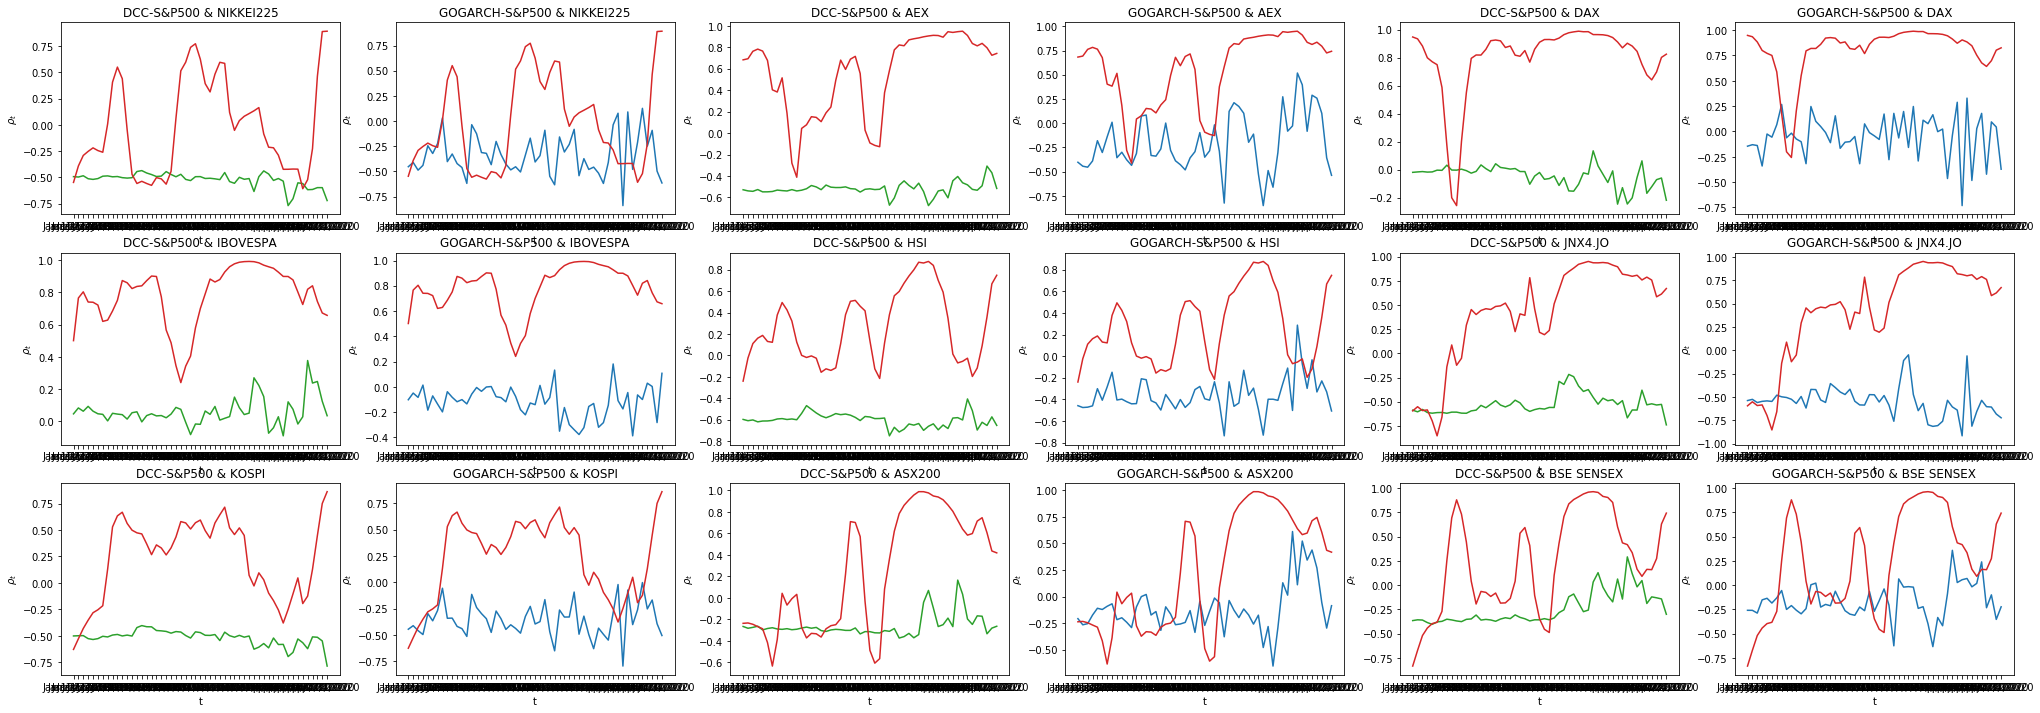

In [247]:
#Plot all of the USA's forecasted and actual correlations (for comparison)
fig,ax = plt.subplots(nrows=3, ncols=6, figsize=(35,12));
ax[0,0].plot(rho_dcc_usa_jap.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,0], 'tab:red')
ax[0,0].set_title('DCC-S&P500 & NIKKEI225')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_usa_jap.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,0], 'tab:red')
ax[0,1].set_title('GOGARCH-S&P500 & NIKKEI225')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[0,2].plot(rho_dcc_usa_nl.iloc[9:], 'tab:green')
ax[0,2].plot(df_test_corr.iloc[9:,1], 'tab:red')
ax[0,2].set_title('DCC-S&P500 & AEX')
ax[0,2].set_ylabel(r'$\rho_{t}$')
ax[0,2].set_xlabel('t');
ax[0,3].plot(rho_gogarch_usa_nl.iloc[9:], 'tab:blue')
ax[0,3].plot(df_test_corr.iloc[9:,1], 'tab:red')
ax[0,3].set_title('GOGARCH-S&P500 & AEX')
ax[0,3].set_ylabel(r'$\rho_{t}$')
ax[0,3].set_xlabel('t');
ax[0,4].plot(rho_dcc_usa_ger.iloc[9:], 'tab:green')
ax[0,4].plot(df_test_corr.iloc[9:,2], 'tab:red')
ax[0,4].set_title('DCC-S&P500 & DAX')
ax[0,4].set_ylabel(r'$\rho_{t}$')
ax[0,4].set_xlabel('t');
ax[0,5].plot(rho_gogarch_usa_ger.iloc[9:], 'tab:blue')
ax[0,5].plot(df_test_corr.iloc[9:,2], 'tab:red')
ax[0,5].set_title('GOGARCH-S&P500 & DAX')
ax[0,5].set_ylabel(r'$\rho_{t}$')
ax[0,5].set_xlabel('t');
ax[1,0].plot(rho_dcc_usa_br.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,3], 'tab:red')
ax[1,0].set_title('DCC-S&P500 & IBOVESPA')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_usa_br.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,3], 'tab:red')
ax[1,1].set_title('GOGARCH-S&P500 & IBOVESPA')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');
ax[1,2].plot(rho_dcc_usa_hk.iloc[9:], 'tab:green')
ax[1,2].plot(df_test_corr.iloc[9:,4], 'tab:red')
ax[1,2].set_title('DCC-S&P500 & HSI')
ax[1,2].set_ylabel(r'$\rho_{t}$')
ax[1,2].set_xlabel('t');
ax[1,3].plot(rho_gogarch_usa_hk.iloc[9:], 'tab:blue')
ax[1,3].plot(df_test_corr.iloc[9:,4], 'tab:red')
ax[1,3].set_title('GOGARCH-S&P500 & HSI')
ax[1,3].set_ylabel(r'$\rho_{t}$')
ax[1,3].set_xlabel('t');
ax[1,4].plot(rho_dcc_usa_sa.iloc[9:], 'tab:green')
ax[1,4].plot(df_test_corr.iloc[9:,5], 'tab:red')
ax[1,4].set_title('DCC-S&P500 & JNX4.JO')
ax[1,4].set_ylabel(r'$\rho_{t}$')
ax[1,4].set_xlabel('t');
ax[1,5].plot(rho_gogarch_usa_sa.iloc[9:], 'tab:blue')
ax[1,5].plot(df_test_corr.iloc[9:,5], 'tab:red')
ax[1,5].set_title('GOGARCH-S&P500 & JNX4.JO')
ax[1,5].set_ylabel(r'$\rho_{t}$')
ax[1,5].set_xlabel('t');
ax[2,0].plot(rho_dcc_usa_sk.iloc[9:], 'tab:green')
ax[2,0].plot(df_test_corr.iloc[9:,6], 'tab:red')
ax[2,0].set_title('DCC-S&P500 & KOSPI')
ax[2,0].set_ylabel(r'$\rho_{t}$')
ax[2,0].set_xlabel('t');
ax[2,1].plot(rho_gogarch_usa_sk.iloc[9:], 'tab:blue')
ax[2,1].plot(df_test_corr.iloc[9:,6], 'tab:red')
ax[2,1].set_title('GOGARCH-S&P500 & KOSPI')
ax[2,1].set_ylabel(r'$\rho_{t}$')
ax[2,1].set_xlabel('t');
ax[2,2].plot(rho_dcc_usa_au.iloc[9:], 'tab:green')
ax[2,2].plot(df_test_corr.iloc[9:,7], 'tab:red')
ax[2,2].set_title('DCC-S&P500 & ASX200')
ax[2,2].set_ylabel(r'$\rho_{t}$')
ax[2,2].set_xlabel('t');
ax[2,3].plot(rho_gogarch_usa_au.iloc[9:], 'tab:blue')
ax[2,3].plot(df_test_corr.iloc[9:,7], 'tab:red')
ax[2,3].set_title('GOGARCH-S&P500 & ASX200')
ax[2,3].set_ylabel(r'$\rho_{t}$')
ax[2,3].set_xlabel('t');
ax[2,4].plot(rho_dcc_usa_ind.iloc[9:], 'tab:green')
ax[2,4].plot(df_test_corr.iloc[9:,8], 'tab:red')
ax[2,4].set_title('DCC-S&P500 & BSE SENSEX')
ax[2,4].set_ylabel(r'$\rho_{t}$')
ax[2,4].set_xlabel('t');
ax[2,5].plot(rho_gogarch_usa_ind.iloc[9:], 'tab:blue')
ax[2,5].plot(df_test_corr.iloc[9:,8], 'tab:red')
ax[2,5].set_title('GOGARCH-S&P500 & BSE SENSEX')
ax[2,5].set_ylabel(r'$\rho_{t}$')
ax[2,5].set_xlabel('t');
tikz_save('fig.tikz')

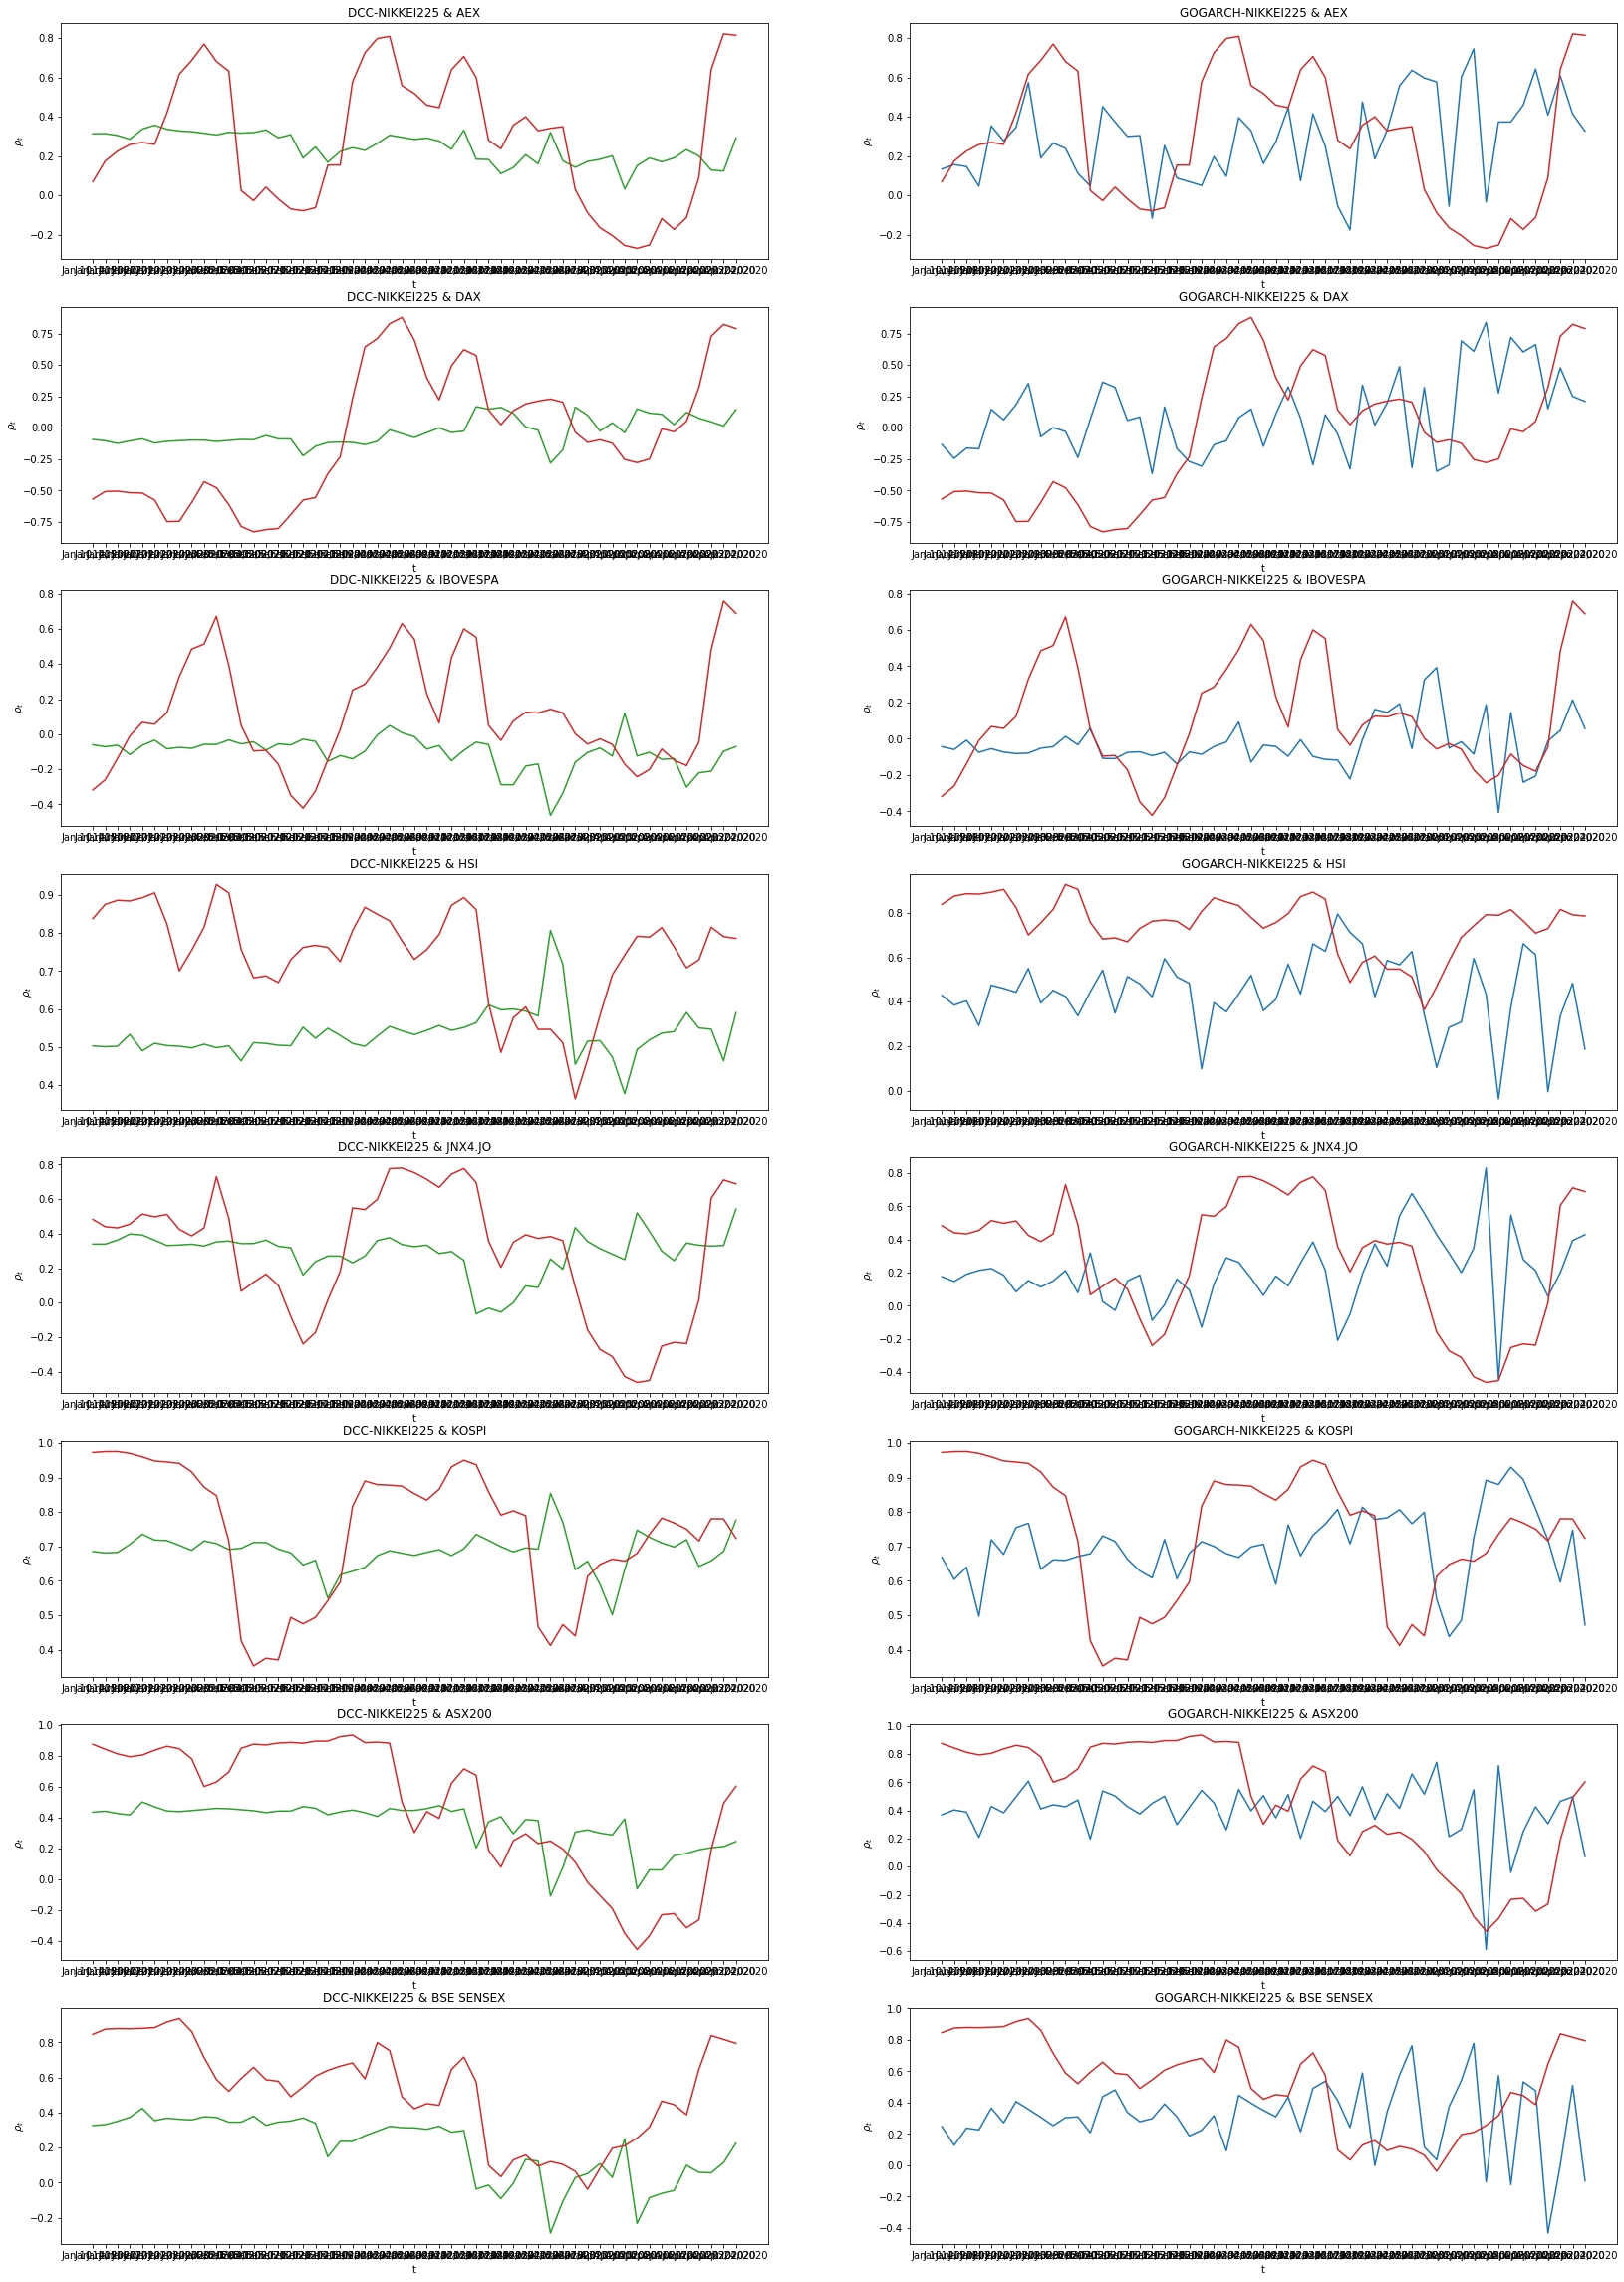

In [184]:
#Separate and plot all of JAPAN's remaining forecasted and actual correlations (for comparison)
rho_dcc_jap_nl = rho_dcc[1,2,:]
rho_dcc_jap_nl = pd.Series(rho_dcc_jap_nl, index=df_test_corr.index, name='Corr_JAP_NL')

rho_gogarch_jap_nl = rho_gogarch[1,2,:]
rho_gogarch_jap_nl = pd.Series(rho_gogarch_jap_nl, index=df_test_corr.index, name='Corr_JAP_NL')

rho_dcc_jap_ger = rho_dcc[1,3,:]
rho_dcc_jap_ger = pd.Series(rho_dcc_jap_ger, index=df_test_corr.index, name='Corr_JAP_GER')

rho_gogarch_jap_ger = rho_gogarch[1,3,:]
rho_gogarch_jap_ger = pd.Series(rho_gogarch_jap_ger, index=df_test_corr.index, name='Corr_JAP_GER')

rho_dcc_jap_br = rho_dcc[1,4,:]
rho_dcc_jap_br = pd.Series(rho_dcc_jap_br, index=df_test_corr.index, name='Corr_JAP_BR')

rho_gogarch_jap_br = rho_gogarch[1,4,:]
rho_gogarch_jap_br = pd.Series(rho_gogarch_jap_br, index=df_test_corr.index, name='Corr_JAP_BR')

rho_dcc_jap_hk = rho_dcc[1,5,:]
rho_dcc_jap_hk = pd.Series(rho_dcc_jap_hk, index=df_test_corr.index, name='Corr_JAP_HK')

rho_gogarch_jap_hk = rho_gogarch[1,5,:]
rho_gogarch_jap_hk = pd.Series(rho_gogarch_jap_hk, index=df_test_corr.index, name='Corr_JAP_HK')

rho_dcc_jap_sa = rho_dcc[1,6,:]
rho_dcc_jap_sa = pd.Series(rho_dcc_jap_sa, index=df_test_corr.index, name='Corr_JAP_SA')

rho_gogarch_jap_sa = rho_gogarch[1,6,:]
rho_gogarch_jap_sa = pd.Series(rho_gogarch_jap_sa, index=df_test_corr.index, name='Corr_JAP_SA')

rho_dcc_jap_sk = rho_dcc[1,7,:]
rho_dcc_jap_sk = pd.Series(rho_dcc_jap_sk, index=df_test_corr.index, name='Corr_JAP_SK')

rho_gogarch_jap_sk = rho_gogarch[1,7,:]
rho_gogarch_jap_sk = pd.Series(rho_gogarch_jap_sk, index=df_test_corr.index, name='Corr_JAP_SK')

rho_dcc_jap_au = rho_dcc[1,8,:]
rho_dcc_jap_au = pd.Series(rho_dcc_jap_au, index=df_test_corr.index, name='Corr_JAP_AU')

rho_gogarch_jap_au = rho_gogarch[1,8,:]
rho_gogarch_jap_au = pd.Series(rho_gogarch_jap_au, index=df_test_corr.index, name='Corr_JAP_AU')

rho_dcc_jap_ind = rho_dcc[1,9,:]
rho_dcc_jap_ind = pd.Series(rho_dcc_jap_ind, index=df_test_corr.index, name='Corr_JAP_IND')

rho_gogarch_jap_ind = rho_gogarch[1,9,:]
rho_gogarch_jap_ind = pd.Series(rho_gogarch_jap_ind, index=df_test_corr.index, name='Corr_JAP_IND')

fig,ax = plt.subplots(nrows=8, ncols=2, figsize=(28,41));
ax[0,0].plot(rho_dcc_jap_nl.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,9], 'tab:red')
ax[0,0].set_title('DCC-NIKKEI225 & AEX')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_jap_nl.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,9], 'tab:red')
ax[0,1].set_title('GOGARCH-NIKKEI225 & AEX')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[1,0].plot(rho_dcc_jap_ger.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,10], 'tab:red')
ax[1,0].set_title('DCC-NIKKEI225 & DAX')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_jap_ger.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,10], 'tab:red')
ax[1,1].set_title('GOGARCH-NIKKEI225 & DAX')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');
ax[2,0].plot(rho_dcc_jap_br.iloc[9:], 'tab:green')
ax[2,0].plot(df_test_corr.iloc[9:,11], 'tab:red')
ax[2,0].set_title('DDC-NIKKEI225 & IBOVESPA')
ax[2,0].set_ylabel(r'$\rho_{t}$')
ax[2,0].set_xlabel('t');
ax[2,1].plot(rho_gogarch_jap_br.iloc[9:], 'tab:blue')
ax[2,1].plot(df_test_corr.iloc[9:,11], 'tab:red')
ax[2,1].set_title('GOGARCH-NIKKEI225 & IBOVESPA')
ax[2,1].set_ylabel(r'$\rho_{t}$')
ax[2,1].set_xlabel('t');
ax[3,0].plot(rho_dcc_jap_hk.iloc[9:], 'tab:green')
ax[3,0].plot(df_test_corr.iloc[9:,12], 'tab:red')
ax[3,0].set_title('DCC-NIKKEI225 & HSI')
ax[3,0].set_ylabel(r'$\rho_{t}$')
ax[3,0].set_xlabel('t');
ax[3,1].plot(rho_gogarch_jap_hk.iloc[9:], 'tab:blue')
ax[3,1].plot(df_test_corr.iloc[9:,12], 'tab:red')
ax[3,1].set_title('GOGARCH-NIKKEI225 & HSI')
ax[3,1].set_ylabel(r'$\rho_{t}$')
ax[3,1].set_xlabel('t');
ax[4,0].plot(rho_dcc_jap_sa.iloc[9:], 'tab:green')
ax[4,0].plot(df_test_corr.iloc[9:,13], 'tab:red')
ax[4,0].set_title('DCC-NIKKEI225 & JNX4.JO')
ax[4,0].set_ylabel(r'$\rho_{t}$')
ax[4,0].set_xlabel('t');
ax[4,1].plot(rho_gogarch_jap_sa.iloc[9:], 'tab:blue')
ax[4,1].plot(df_test_corr.iloc[9:,13], 'tab:red')
ax[4,1].set_title('GOGARCH-NIKKEI225 & JNX4.JO')
ax[4,1].set_ylabel(r'$\rho_{t}$')
ax[4,1].set_xlabel('t');
ax[5,0].plot(rho_dcc_jap_sk.iloc[9:], 'tab:green')
ax[5,0].plot(df_test_corr.iloc[9:,14], 'tab:red')
ax[5,0].set_title('DCC-NIKKEI225 & KOSPI')
ax[5,0].set_ylabel(r'$\rho_{t}$')
ax[5,0].set_xlabel('t');
ax[5,1].plot(rho_gogarch_jap_sk.iloc[9:], 'tab:blue')
ax[5,1].plot(df_test_corr.iloc[9:,14], 'tab:red')
ax[5,1].set_title('GOGARCH-NIKKEI225 & KOSPI')
ax[5,1].set_ylabel(r'$\rho_{t}$')
ax[5,1].set_xlabel('t');
ax[6,0].plot(rho_dcc_jap_au.iloc[9:], 'tab:green')
ax[6,0].plot(df_test_corr.iloc[9:,15], 'tab:red')
ax[6,0].set_title('DCC-NIKKEI225 & ASX200')
ax[6,0].set_ylabel(r'$\rho_{t}$')
ax[6,0].set_xlabel('t');
ax[6,1].plot(rho_gogarch_jap_au.iloc[9:], 'tab:blue')
ax[6,1].plot(df_test_corr.iloc[9:,15], 'tab:red')
ax[6,1].set_title('GOGARCH-NIKKEI225 & ASX200')
ax[6,1].set_ylabel(r'$\rho_{t}$')
ax[6,1].set_xlabel('t');
ax[7,0].plot(rho_dcc_jap_ind.iloc[9:], 'tab:green')
ax[7,0].plot(df_test_corr.iloc[9:,16], 'tab:red')
ax[7,0].set_title('DCC-NIKKEI225 & BSE SENSEX')
ax[7,0].set_ylabel(r'$\rho_{t}$')
ax[7,0].set_xlabel('t');
ax[7,1].plot(rho_gogarch_jap_ind.iloc[9:], 'tab:blue')
ax[7,1].plot(df_test_corr.iloc[9:,16], 'tab:red')
ax[7,1].set_title('GOGARCH-NIKKEI225 & BSE SENSEX')
ax[7,1].set_ylabel(r'$\rho_{t}$')
ax[7,1].set_xlabel('t');

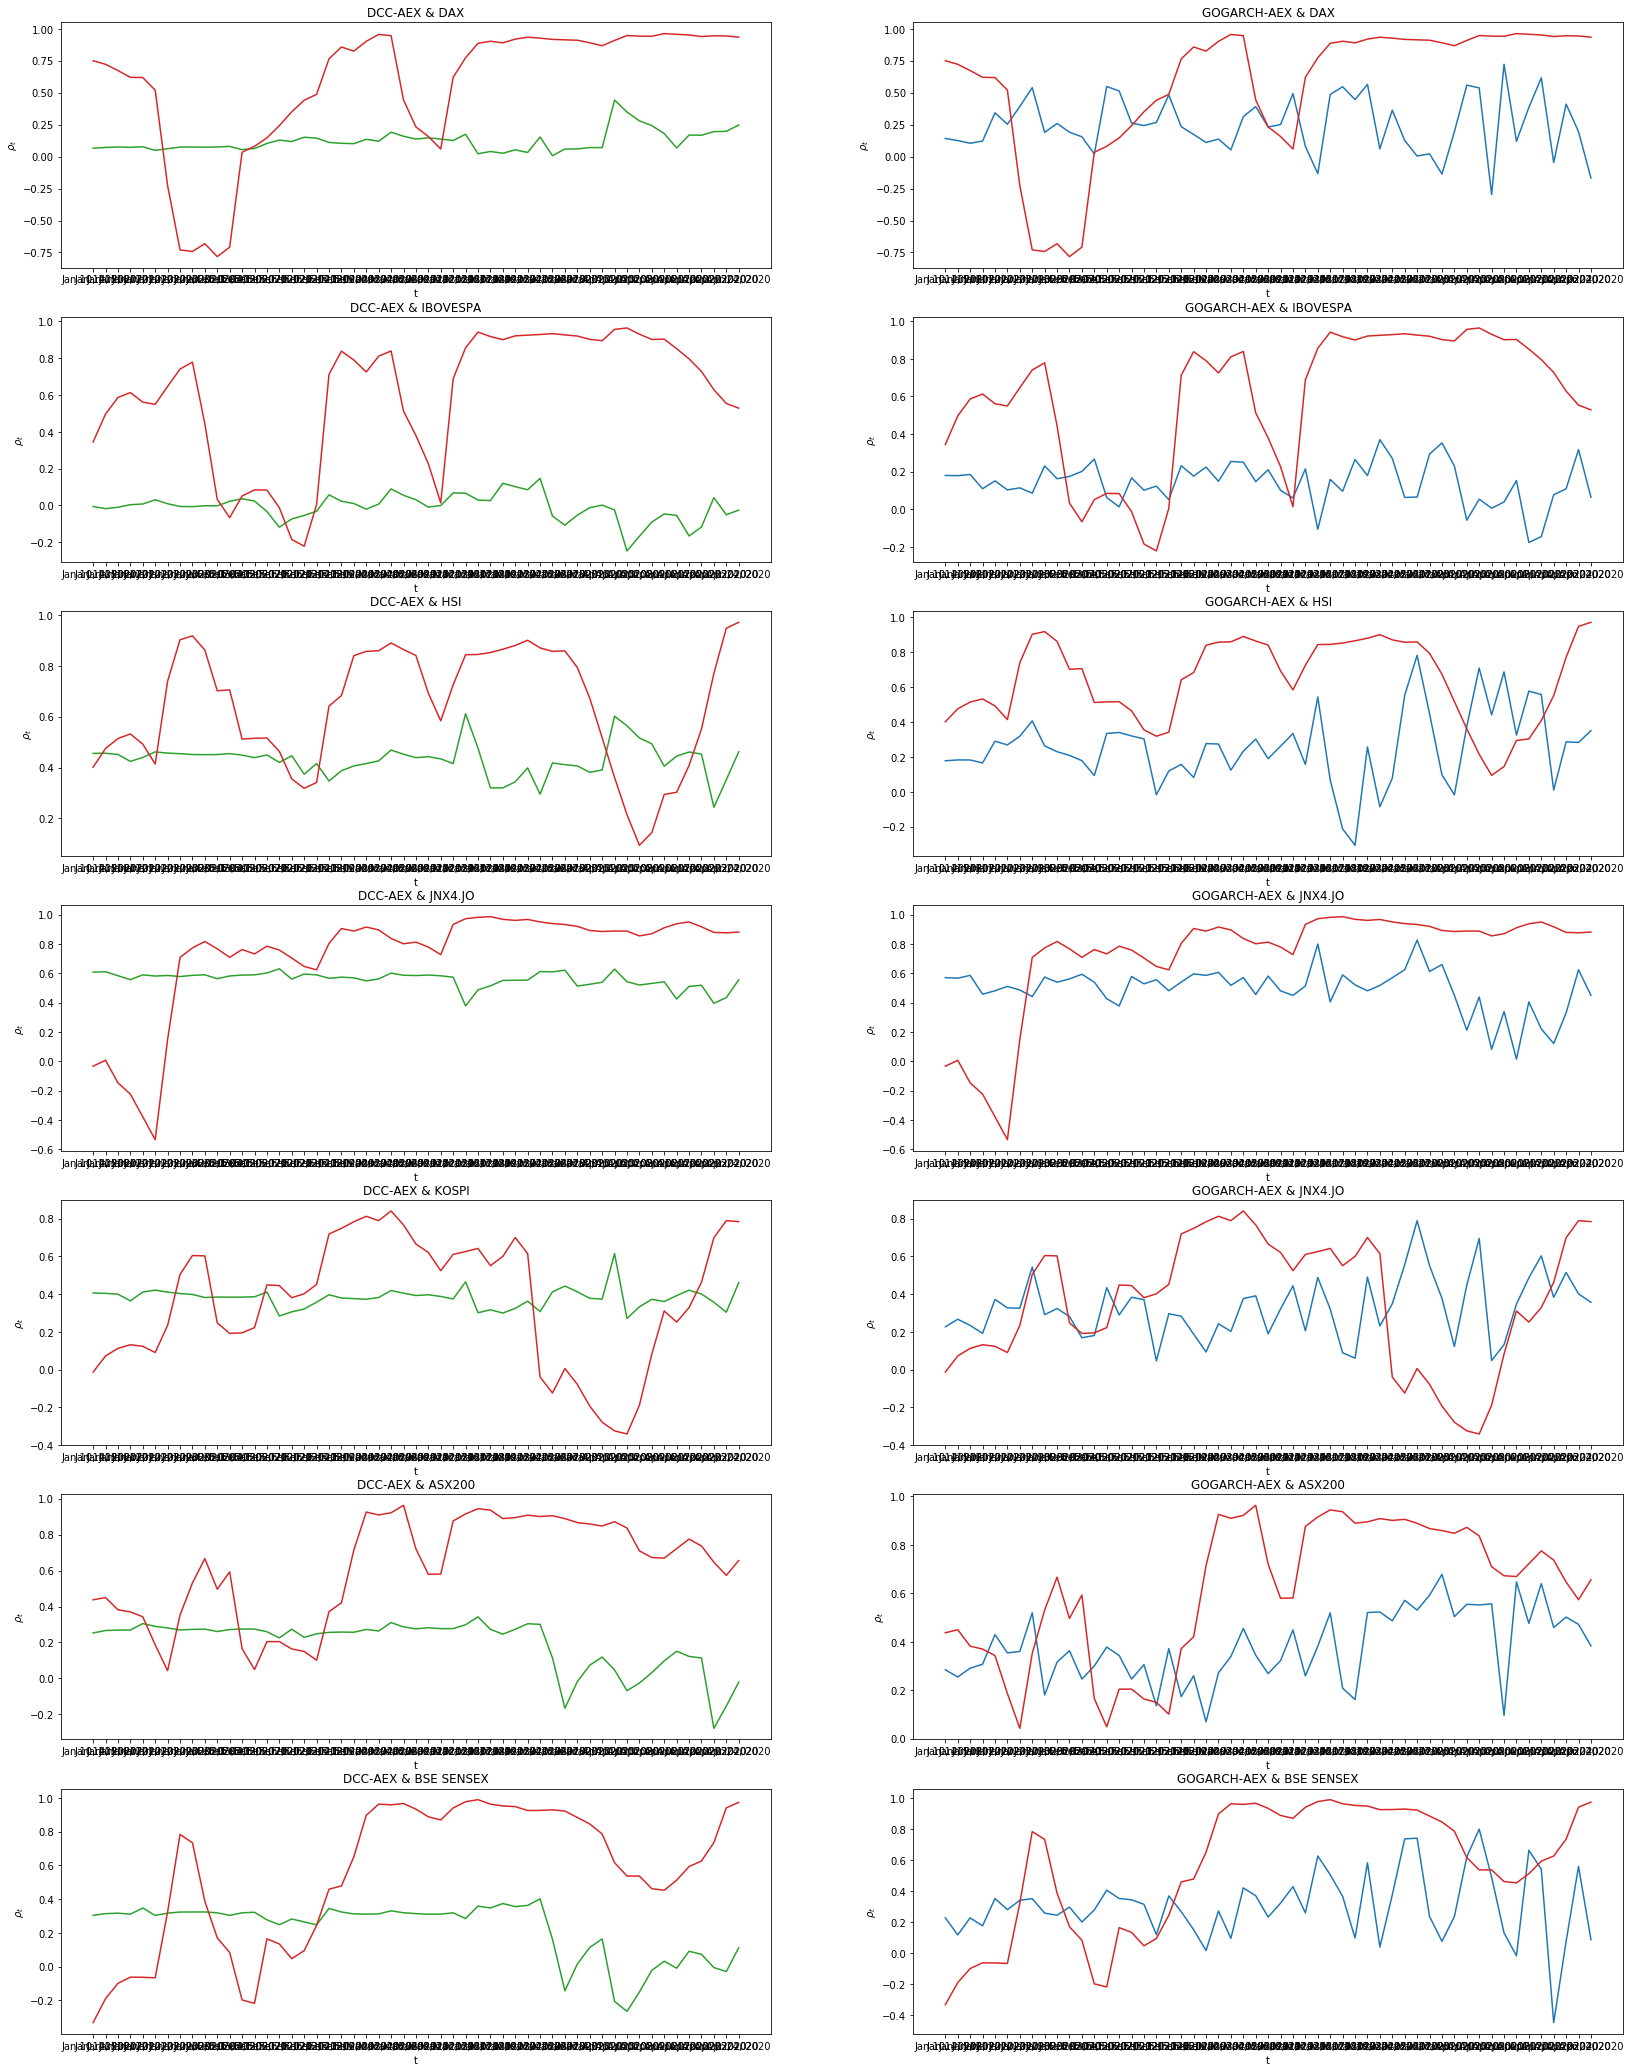

In [181]:
#Separate and plot all of NETHERLAND's remaining forecasted and actual correlations (for comparison)
rho_dcc_nl_ger = rho_dcc[2,3,:]
rho_dcc_nl_ger = pd.Series(rho_dcc_nl_ger, index=df_test_corr.index, name='Corr_NL_GER')

rho_gogarch_nl_ger = rho_gogarch[2,3,:]
rho_gogarch_nl_ger = pd.Series(rho_gogarch_nl_ger, index=df_test_corr.index, name='Corr_NL_GER')

rho_dcc_nl_br = rho_dcc[2,4,:]
rho_dcc_nl_br = pd.Series(rho_dcc_nl_br, index=df_test_corr.index, name='Corr_NL_BR')

rho_gogarch_nl_br = rho_gogarch[2,4,:]
rho_gogarch_nl_br = pd.Series(rho_gogarch_nl_br, index=df_test_corr.index, name='Corr_NL_BR')

rho_dcc_nl_hk = rho_dcc[2,5,:]
rho_dcc_nl_hk = pd.Series(rho_dcc_nl_hk, index=df_test_corr.index, name='Corr_NL_HK')

rho_gogarch_nl_hk = rho_gogarch[2,5,:]
rho_gogarch_nl_hk = pd.Series(rho_gogarch_nl_hk, index=df_test_corr.index, name='Corr_NL_HK')

rho_dcc_nl_sa = rho_dcc[2,6,:]
rho_dcc_nl_sa = pd.Series(rho_dcc_nl_sa, index=df_test_corr.index, name='Corr_NL_SA')

rho_gogarch_nl_sa = rho_gogarch[2,6,:]
rho_gogarch_nl_sa = pd.Series(rho_gogarch_nl_sa, index=df_test_corr.index, name='Corr_NL_SA')

rho_dcc_nl_sk = rho_dcc[2,7,:]
rho_dcc_nl_sk = pd.Series(rho_dcc_nl_sk, index=df_test_corr.index, name='Corr_NL_SK')

rho_gogarch_nl_sk = rho_gogarch[2,7,:]
rho_gogarch_nl_sk = pd.Series(rho_gogarch_nl_sk, index=df_test_corr.index, name='Corr_NL_SK')

rho_dcc_nl_au = rho_dcc[2,8,:]
rho_dcc_nl_au = pd.Series(rho_dcc_nl_au, index=df_test_corr.index, name='Corr_NL_AU')

rho_gogarch_nl_au = rho_gogarch[2,8,:]
rho_gogarch_nl_au = pd.Series(rho_gogarch_nl_au, index=df_test_corr.index, name='Corr_NL_AU')

rho_dcc_nl_ind = rho_dcc[2,9,:]
rho_dcc_nl_ind = pd.Series(rho_dcc_nl_ind, index=df_test_corr.index, name='Corr_NL_IND')

rho_gogarch_nl_ind = rho_gogarch[2,9,:]
rho_gogarch_nl_ind = pd.Series(rho_gogarch_nl_ind, index=df_test_corr.index, name='Corr_NL_IND')

fig,ax = plt.subplots(nrows=7, ncols=2, figsize=(28,37));
ax[0,0].plot(rho_dcc_nl_ger.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,17], 'tab:red')
ax[0,0].set_title('DCC-AEX & DAX')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_nl_ger.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,17], 'tab:red')
ax[0,1].set_title('GOGARCH-AEX & DAX')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[1,0].plot(rho_dcc_nl_br.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,18], 'tab:red')
ax[1,0].set_title('DCC-AEX & IBOVESPA')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_nl_br.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,18], 'tab:red')
ax[1,1].set_title('GOGARCH-AEX & IBOVESPA')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');
ax[2,0].plot(rho_dcc_nl_hk.iloc[9:], 'tab:green')
ax[2,0].plot(df_test_corr.iloc[9:,19], 'tab:red')
ax[2,0].set_title('DCC-AEX & HSI')
ax[2,0].set_ylabel(r'$\rho_{t}$')
ax[2,0].set_xlabel('t');
ax[2,1].plot(rho_gogarch_nl_hk.iloc[9:], 'tab:blue')
ax[2,1].plot(df_test_corr.iloc[9:,19], 'tab:red')
ax[2,1].set_title('GOGARCH-AEX & HSI')
ax[2,1].set_ylabel(r'$\rho_{t}$')
ax[2,1].set_xlabel('t');
ax[3,0].plot(rho_dcc_nl_sa.iloc[9:], 'tab:green')
ax[3,0].plot(df_test_corr.iloc[9:,20], 'tab:red')
ax[3,0].set_title('DCC-AEX & JNX4.JO')
ax[3,0].set_ylabel(r'$\rho_{t}$')
ax[3,0].set_xlabel('t');
ax[3,1].plot(rho_gogarch_nl_sa.iloc[9:], 'tab:blue')
ax[3,1].plot(df_test_corr.iloc[9:,20], 'tab:red')
ax[3,1].set_title('GOGARCH-AEX & JNX4.JO')
ax[3,1].set_ylabel(r'$\rho_{t}$')
ax[3,1].set_xlabel('t');
ax[4,0].plot(rho_dcc_nl_sk.iloc[9:], 'tab:green')
ax[4,0].plot(df_test_corr.iloc[9:,21], 'tab:red')
ax[4,0].set_title('DCC-AEX & KOSPI')
ax[4,0].set_ylabel(r'$\rho_{t}$')
ax[4,0].set_xlabel('t');
ax[4,1].plot(rho_gogarch_nl_sk.iloc[9:], 'tab:blue')
ax[4,1].plot(df_test_corr.iloc[9:,21], 'tab:red')
ax[4,1].set_title('GOGARCH-AEX & JNX4.JO')
ax[4,1].set_ylabel(r'$\rho_{t}$')
ax[4,1].set_xlabel('t');
ax[5,0].plot(rho_dcc_nl_au.iloc[9:], 'tab:green')
ax[5,0].plot(df_test_corr.iloc[9:,22], 'tab:red')
ax[5,0].set_title('DCC-AEX & ASX200')
ax[5,0].set_ylabel(r'$\rho_{t}$')
ax[5,0].set_xlabel('t');
ax[5,1].plot(rho_gogarch_nl_au.iloc[9:], 'tab:blue')
ax[5,1].plot(df_test_corr.iloc[9:,22], 'tab:red')
ax[5,1].set_title('GOGARCH-AEX & ASX200')
ax[5,1].set_ylabel(r'$\rho_{t}$')
ax[5,1].set_xlabel('t');
ax[6,0].plot(rho_dcc_nl_ind.iloc[9:], 'tab:green')
ax[6,0].plot(df_test_corr.iloc[9:,23], 'tab:red')
ax[6,0].set_title('DCC-AEX & BSE SENSEX')
ax[6,0].set_ylabel(r'$\rho_{t}$')
ax[6,0].set_xlabel('t');
ax[6,1].plot(rho_gogarch_nl_ind.iloc[9:], 'tab:blue')
ax[6,1].plot(df_test_corr.iloc[9:,23], 'tab:red')
ax[6,1].set_title('GOGARCH-AEX & BSE SENSEX')
ax[6,1].set_ylabel(r'$\rho_{t}$')
ax[6,1].set_xlabel('t');

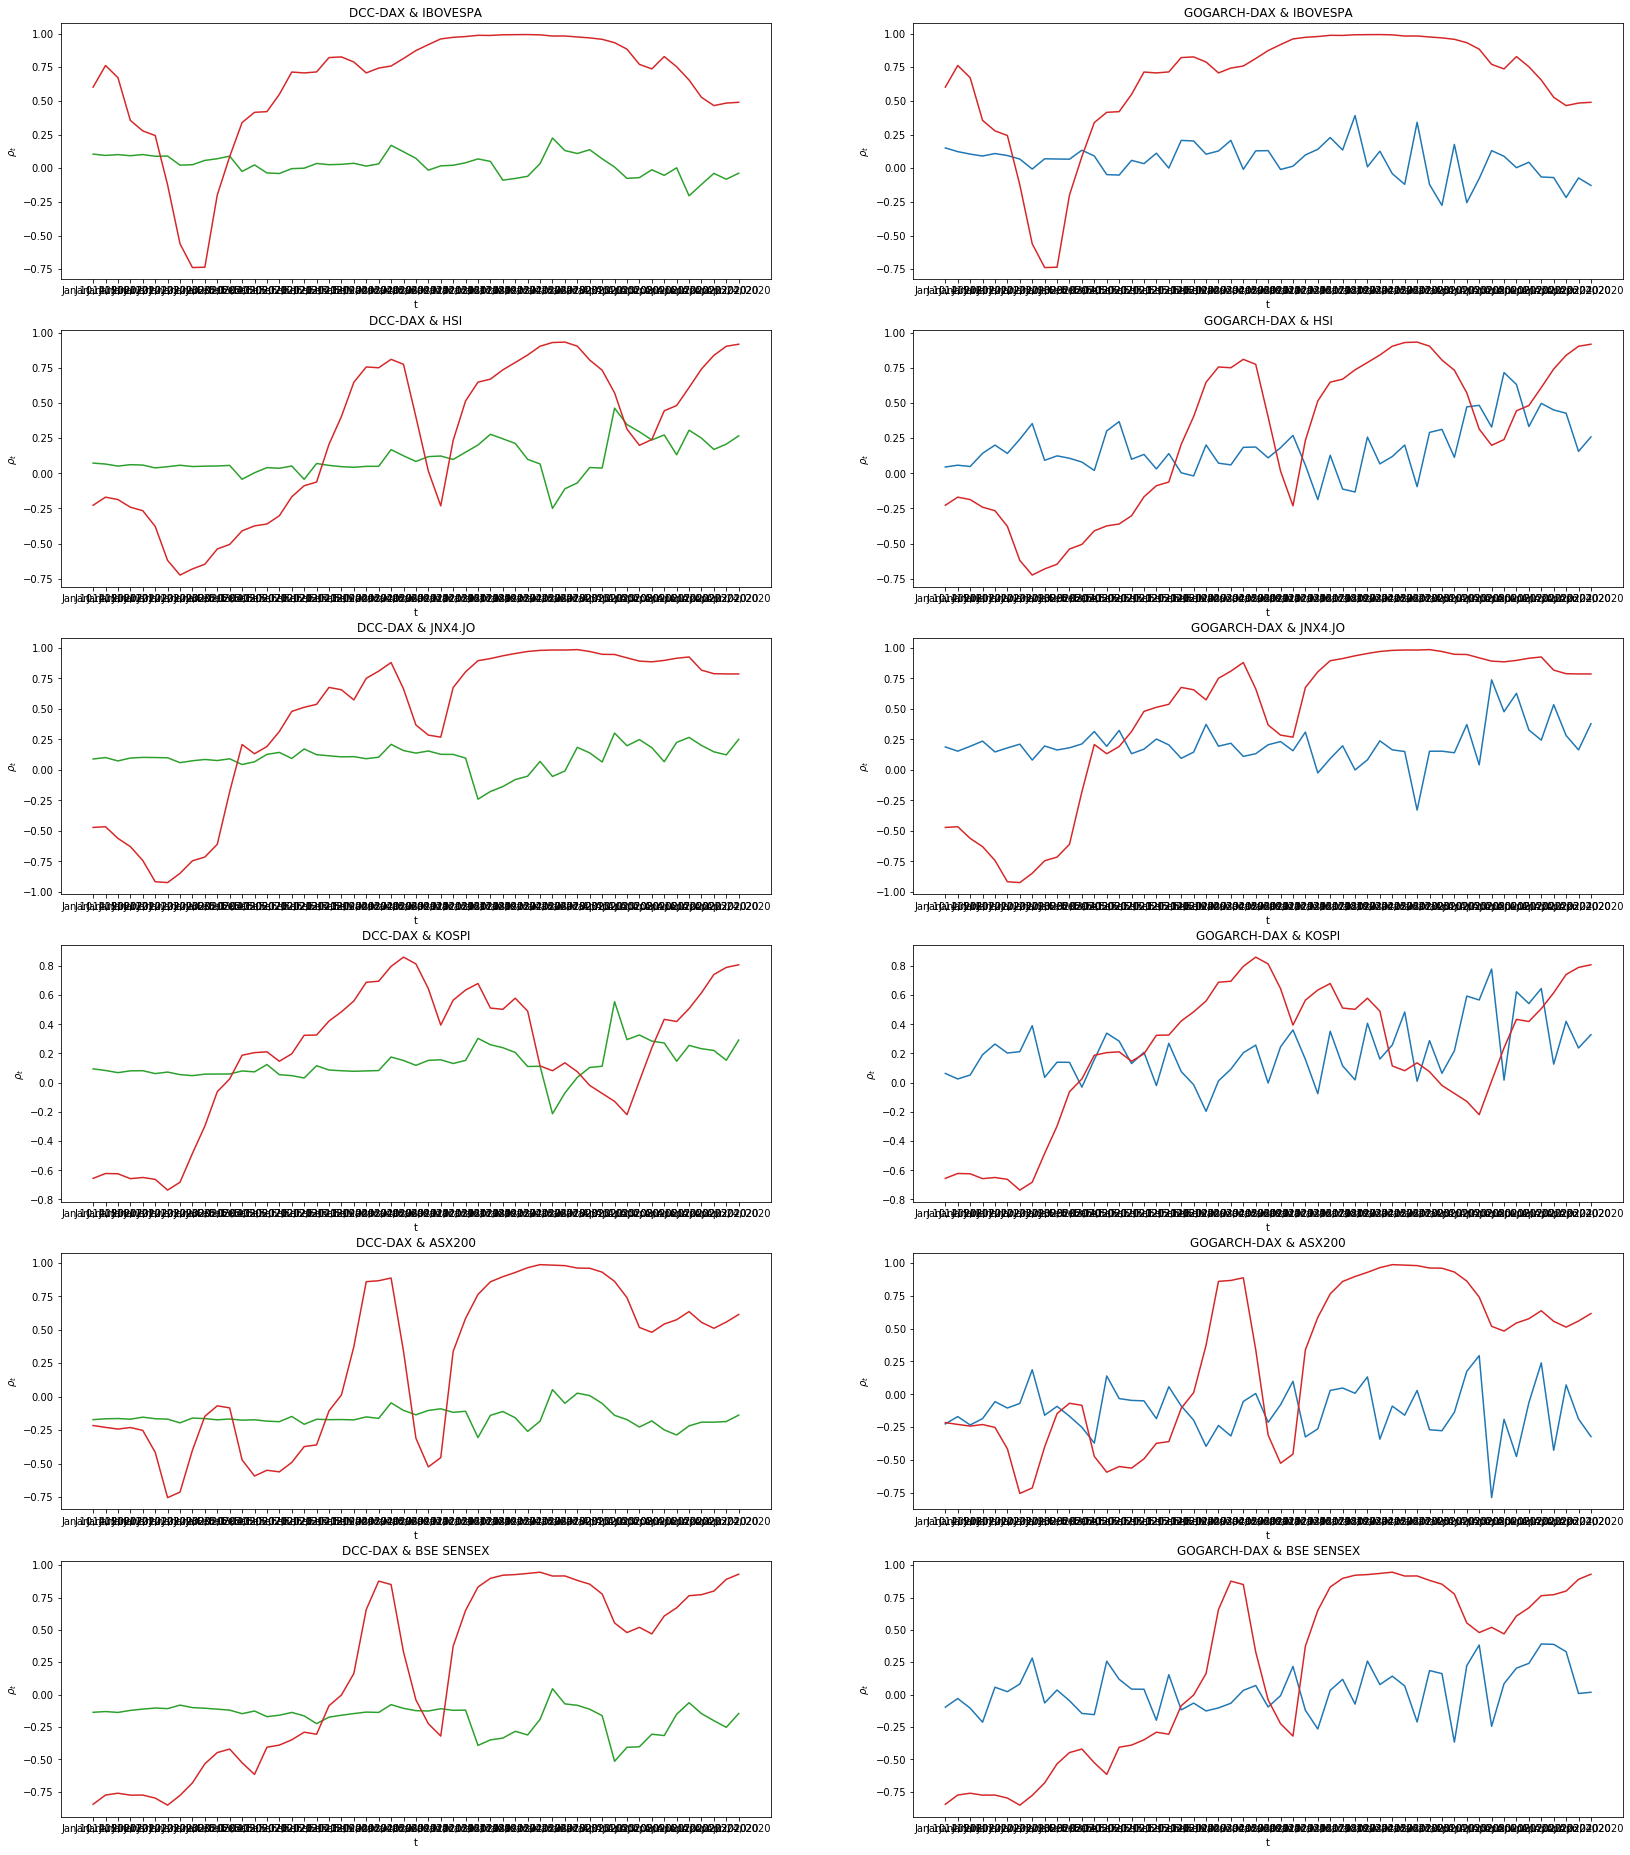

In [169]:
#Separate and plot all of GERMANY's remaining forecasted and actual correlations (for comparison)
rho_dcc_ger_br = rho_dcc[3,4,:]
rho_dcc_ger_br = pd.Series(rho_dcc_ger_br, index=df_test_corr.index, name='Corr_GER_BR')

rho_gogarch_ger_br = rho_gogarch[3,4,:]
rho_gogarch_ger_br = pd.Series(rho_gogarch_ger_br, index=df_test_corr.index, name='Corr_GER_BR')

rho_dcc_ger_hk = rho_dcc[3,5,:]
rho_dcc_ger_hk = pd.Series(rho_dcc_ger_hk, index=df_test_corr.index, name='Corr_GER_HK')

rho_gogarch_ger_hk = rho_gogarch[3,5,:]
rho_gogarch_ger_hk = pd.Series(rho_gogarch_ger_hk, index=df_test_corr.index, name='Corr_GER_HK')

rho_dcc_ger_sa = rho_dcc[3,6,:]
rho_dcc_ger_sa = pd.Series(rho_dcc_ger_sa, index=df_test_corr.index, name='Corr_GER_SA')

rho_gogarch_ger_sa = rho_gogarch[3,6,:]
rho_gogarch_ger_sa = pd.Series(rho_gogarch_ger_sa, index=df_test_corr.index, name='Corr_GER_SA')

rho_dcc_ger_sk = rho_dcc[3,7,:]
rho_dcc_ger_sk = pd.Series(rho_dcc_ger_sk, index=df_test_corr.index, name='Corr_GER_SK')

rho_gogarch_ger_sk = rho_gogarch[3,7,:]
rho_gogarch_ger_sk = pd.Series(rho_gogarch_ger_sk, index=df_test_corr.index, name='Corr_GER_SK')

rho_dcc_ger_au = rho_dcc[3,8,:]
rho_dcc_ger_au = pd.Series(rho_dcc_ger_au, index=df_test_corr.index, name='Corr_GER_AU')

rho_gogarch_ger_au = rho_gogarch[3,8,:]
rho_gogarch_ger_au = pd.Series(rho_gogarch_ger_au, index=df_test_corr.index, name='Corr_GER_AU')

rho_dcc_ger_ind = rho_dcc[3,9,:]
rho_dcc_ger_ind = pd.Series(rho_dcc_ger_ind, index=df_test_corr.index, name='Corr_GER_IND')

rho_gogarch_ger_ind = rho_gogarch[3,9,:]
rho_gogarch_ger_ind = pd.Series(rho_gogarch_ger_ind, index=df_test_corr.index, name='Corr_GER_IND')

fig,ax = plt.subplots(nrows=6, ncols=2, figsize=(28,33));
ax[0,0].plot(rho_dcc_ger_br.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,24], 'tab:red')
ax[0,0].set_title('DCC-DAX & IBOVESPA')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_ger_br.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,24], 'tab:red')
ax[0,1].set_title('GOGARCH-DAX & IBOVESPA')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[1,0].plot(rho_dcc_ger_hk.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,25], 'tab:red')
ax[1,0].set_title('DCC-DAX & HSI')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_ger_hk.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,25], 'tab:red')
ax[1,1].set_title('GOGARCH-DAX & HSI')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');
ax[2,0].plot(rho_dcc_ger_sa.iloc[9:], 'tab:green')
ax[2,0].plot(df_test_corr.iloc[9:,26], 'tab:red')
ax[2,0].set_title('DCC-DAX & JNX4.JO')
ax[2,0].set_ylabel(r'$\rho_{t}$')
ax[2,0].set_xlabel('t');
ax[2,1].plot(rho_gogarch_ger_sa.iloc[9:], 'tab:blue')
ax[2,1].plot(df_test_corr.iloc[9:,26], 'tab:red')
ax[2,1].set_title('GOGARCH-DAX & JNX4.JO')
ax[2,1].set_ylabel(r'$\rho_{t}$')
ax[2,1].set_xlabel('t');
ax[3,0].plot(rho_dcc_ger_sk.iloc[9:], 'tab:green')
ax[3,0].plot(df_test_corr.iloc[9:,27], 'tab:red')
ax[3,0].set_title('DCC-DAX & KOSPI')
ax[3,0].set_ylabel(r'$\rho_{t}$')
ax[3,0].set_xlabel('t');
ax[3,1].plot(rho_gogarch_ger_sk.iloc[9:], 'tab:blue')
ax[3,1].plot(df_test_corr.iloc[9:,27], 'tab:red')
ax[3,1].set_title('GOGARCH-DAX & KOSPI')
ax[3,1].set_ylabel(r'$\rho_{t}$')
ax[3,1].set_xlabel('t');
ax[4,0].plot(rho_dcc_ger_au.iloc[9:], 'tab:green')
ax[4,0].plot(df_test_corr.iloc[9:,28], 'tab:red')
ax[4,0].set_title('DCC-DAX & ASX200')
ax[4,0].set_ylabel(r'$\rho_{t}$')
ax[4,0].set_xlabel('t');
ax[4,1].plot(rho_gogarch_ger_au.iloc[9:], 'tab:blue')
ax[4,1].plot(df_test_corr.iloc[9:,28], 'tab:red')
ax[4,1].set_title('GOGARCH-DAX & ASX200')
ax[4,1].set_ylabel(r'$\rho_{t}$')
ax[4,1].set_xlabel('t');
ax[5,0].plot(rho_dcc_ger_ind.iloc[9:], 'tab:green')
ax[5,0].plot(df_test_corr.iloc[9:,29], 'tab:red')
ax[5,0].set_title('DCC-DAX & BSE SENSEX')
ax[5,0].set_ylabel(r'$\rho_{t}$')
ax[5,0].set_xlabel('t');
ax[5,1].plot(rho_gogarch_ger_ind.iloc[9:], 'tab:blue')
ax[5,1].plot(df_test_corr.iloc[9:,29], 'tab:red')
ax[5,1].set_title('GOGARCH-DAX & BSE SENSEX')
ax[5,1].set_ylabel(r'$\rho_{t}$')
ax[5,1].set_xlabel('t');

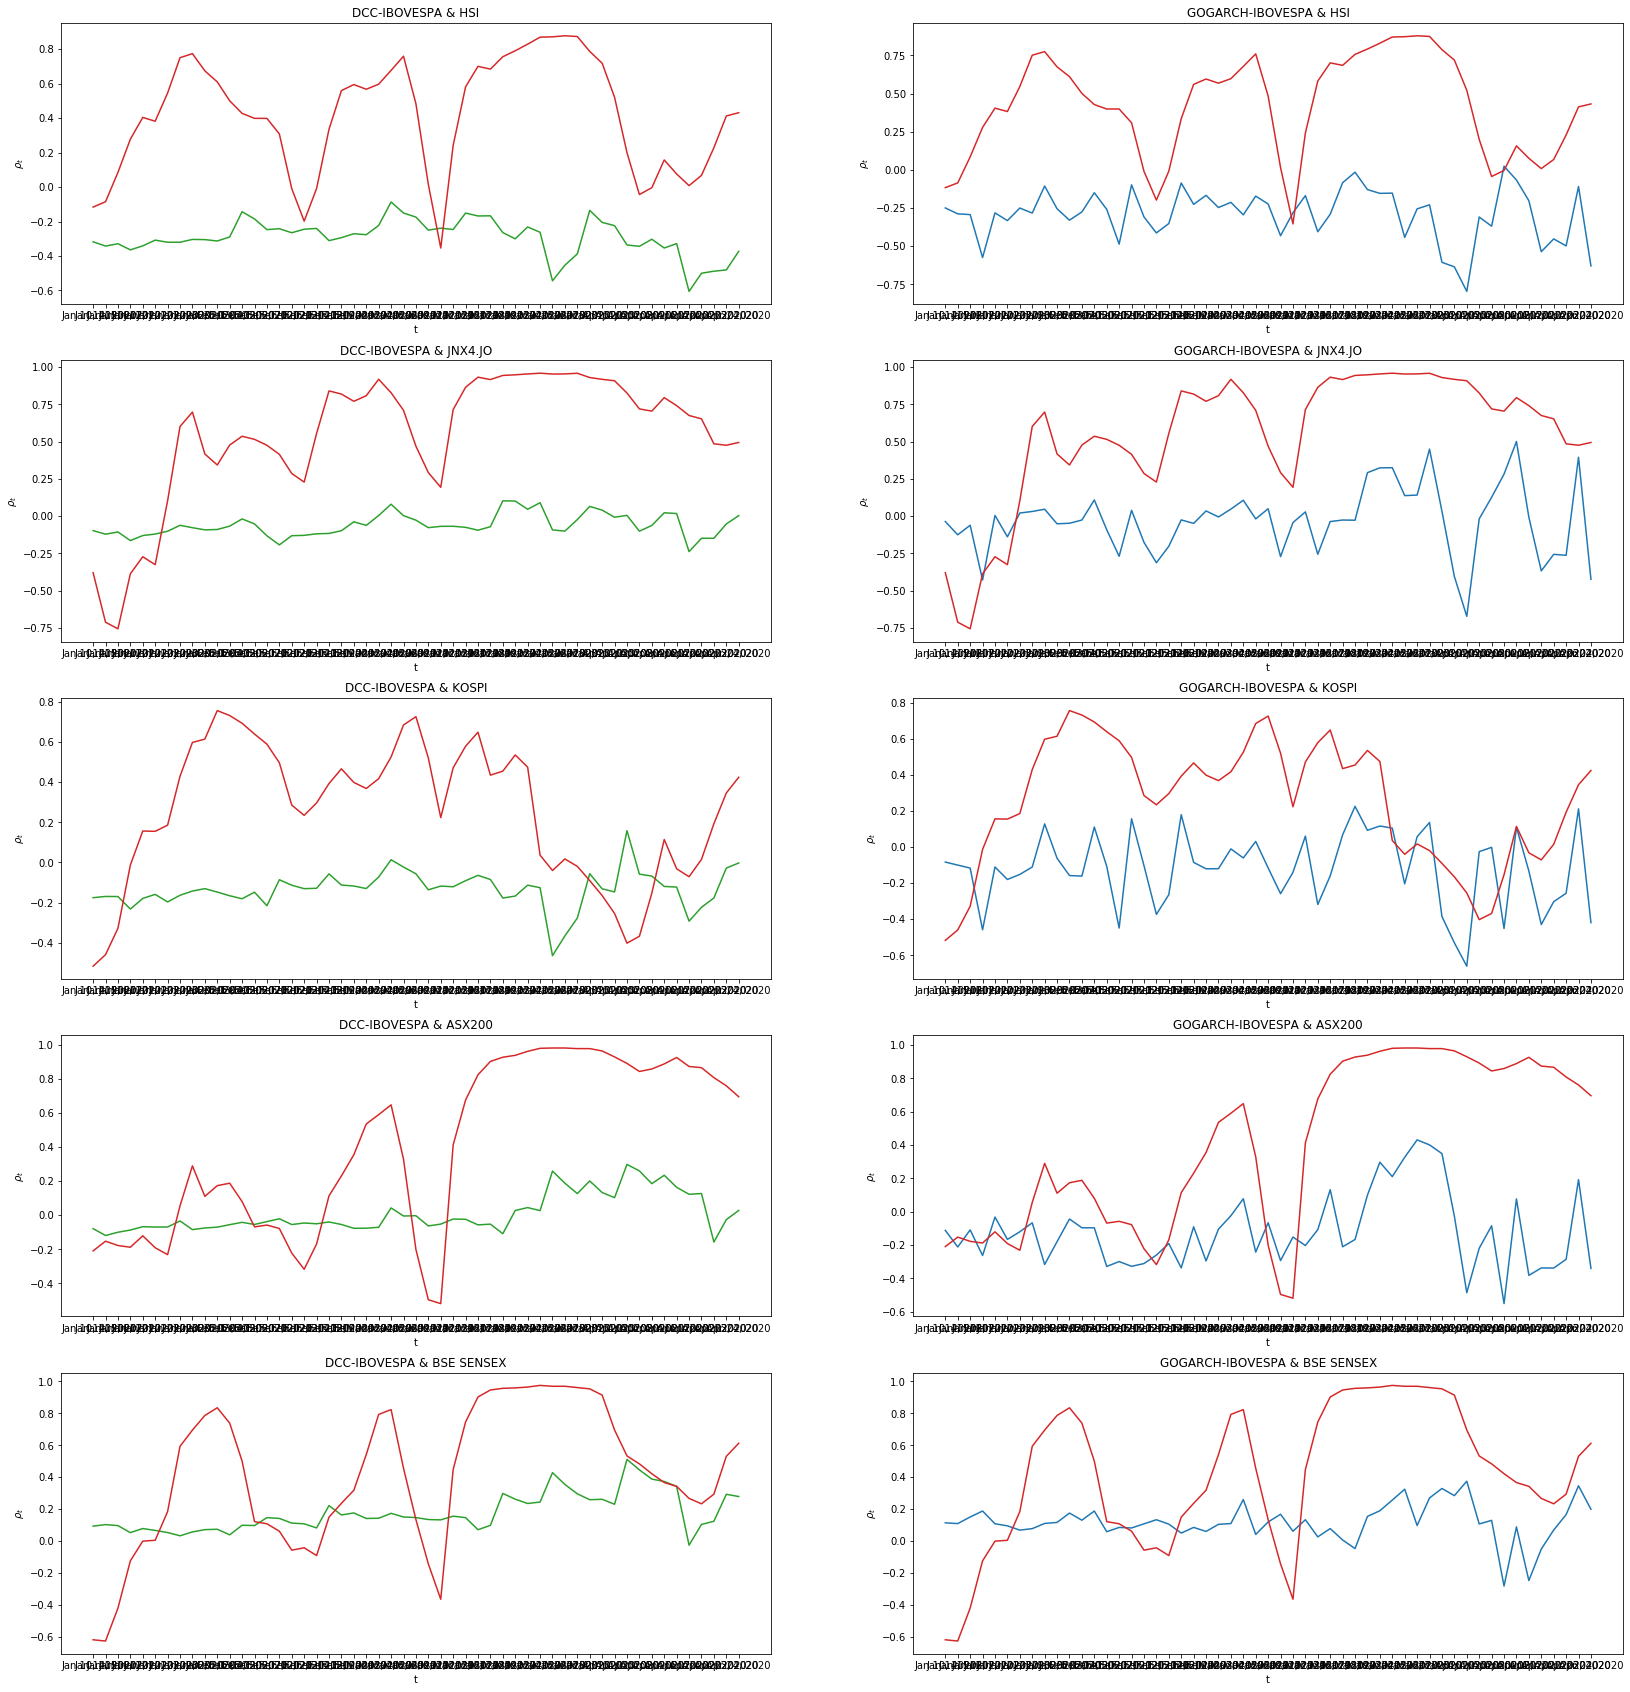

In [170]:
#Separate and plot all of BRAZIL's remaining forecasted and actual correlations (for comparison)
rho_dcc_br_hk = rho_dcc[4,5,:]
rho_dcc_br_hk = pd.Series(rho_dcc_br_hk, index=df_test_corr.index, name='Corr_BR_HK')

rho_gogarch_br_hk = rho_gogarch[4,5,:]
rho_gogarch_br_hk = pd.Series(rho_gogarch_br_hk, index=df_test_corr.index, name='Corr_BR_HK')

rho_dcc_br_sa = rho_dcc[4,6,:]
rho_dcc_br_sa = pd.Series(rho_dcc_br_sa, index=df_test_corr.index, name='Corr_BR_SA')

rho_gogarch_br_sa = rho_gogarch[4,6,:]
rho_gogarch_br_sa = pd.Series(rho_gogarch_br_sa, index=df_test_corr.index, name='Corr_BR_SA')

rho_dcc_br_sk = rho_dcc[4,7,:]
rho_dcc_br_sk = pd.Series(rho_dcc_br_sk, index=df_test_corr.index, name='Corr_BR_SK')

rho_gogarch_br_sk = rho_gogarch[4,7,:]
rho_gogarch_br_sk = pd.Series(rho_gogarch_br_sk, index=df_test_corr.index, name='Corr_BR_SK')

rho_dcc_br_au = rho_dcc[4,8,:]
rho_dcc_br_au = pd.Series(rho_dcc_br_au, index=df_test_corr.index, name='Corr_BR_AU')

rho_gogarch_br_au = rho_gogarch[4,8,:]
rho_gogarch_br_au = pd.Series(rho_gogarch_br_au, index=df_test_corr.index, name='Corr_BR_AU')

rho_dcc_br_ind = rho_dcc[4,9,:]
rho_dcc_br_ind = pd.Series(rho_dcc_br_ind, index=df_test_corr.index, name='Corr_BR_IND')

rho_gogarch_br_ind = rho_gogarch[4,9,:]
rho_gogarch_br_ind = pd.Series(rho_gogarch_br_ind, index=df_test_corr.index, name='Corr_BR_IND')

fig,ax = plt.subplots(nrows=5, ncols=2, figsize=(28,30));
ax[0,0].plot(rho_dcc_br_hk.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,30], 'tab:red')
ax[0,0].set_title('DCC-IBOVESPA & HSI')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_br_hk.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,30], 'tab:red')
ax[0,1].set_title('GOGARCH-IBOVESPA & HSI')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[1,0].plot(rho_dcc_br_sa.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,31], 'tab:red')
ax[1,0].set_title('DCC-IBOVESPA & JNX4.JO')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_br_sa.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,31], 'tab:red')
ax[1,1].set_title('GOGARCH-IBOVESPA & JNX4.JO')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');
ax[2,0].plot(rho_dcc_br_sk.iloc[9:], 'tab:green')
ax[2,0].plot(df_test_corr.iloc[9:,32], 'tab:red')
ax[2,0].set_title('DCC-IBOVESPA & KOSPI')
ax[2,0].set_ylabel(r'$\rho_{t}$')
ax[2,0].set_xlabel('t');
ax[2,1].plot(rho_gogarch_br_sk.iloc[9:], 'tab:blue')
ax[2,1].plot(df_test_corr.iloc[9:,32], 'tab:red')
ax[2,1].set_title('GOGARCH-IBOVESPA & KOSPI')
ax[2,1].set_ylabel(r'$\rho_{t}$')
ax[2,1].set_xlabel('t');
ax[3,0].plot(rho_dcc_br_au.iloc[9:], 'tab:green')
ax[3,0].plot(df_test_corr.iloc[9:,33], 'tab:red')
ax[3,0].set_title('DCC-IBOVESPA & ASX200')
ax[3,0].set_ylabel(r'$\rho_{t}$')
ax[3,0].set_xlabel('t');
ax[3,1].plot(rho_gogarch_br_au.iloc[9:], 'tab:blue')
ax[3,1].plot(df_test_corr.iloc[9:,33], 'tab:red')
ax[3,1].set_title('GOGARCH-IBOVESPA & ASX200')
ax[3,1].set_ylabel(r'$\rho_{t}$')
ax[3,1].set_xlabel('t');
ax[4,0].plot(rho_dcc_br_ind.iloc[9:], 'tab:green')
ax[4,0].plot(df_test_corr.iloc[9:,34], 'tab:red')
ax[4,0].set_title('DCC-IBOVESPA & BSE SENSEX')
ax[4,0].set_ylabel(r'$\rho_{t}$')
ax[4,0].set_xlabel('t');
ax[4,1].plot(rho_gogarch_br_ind.iloc[9:], 'tab:blue')
ax[4,1].plot(df_test_corr.iloc[9:,34], 'tab:red')
ax[4,1].set_title('GOGARCH-IBOVESPA & BSE SENSEX')
ax[4,1].set_ylabel(r'$\rho_{t}$')
ax[4,1].set_xlabel('t');

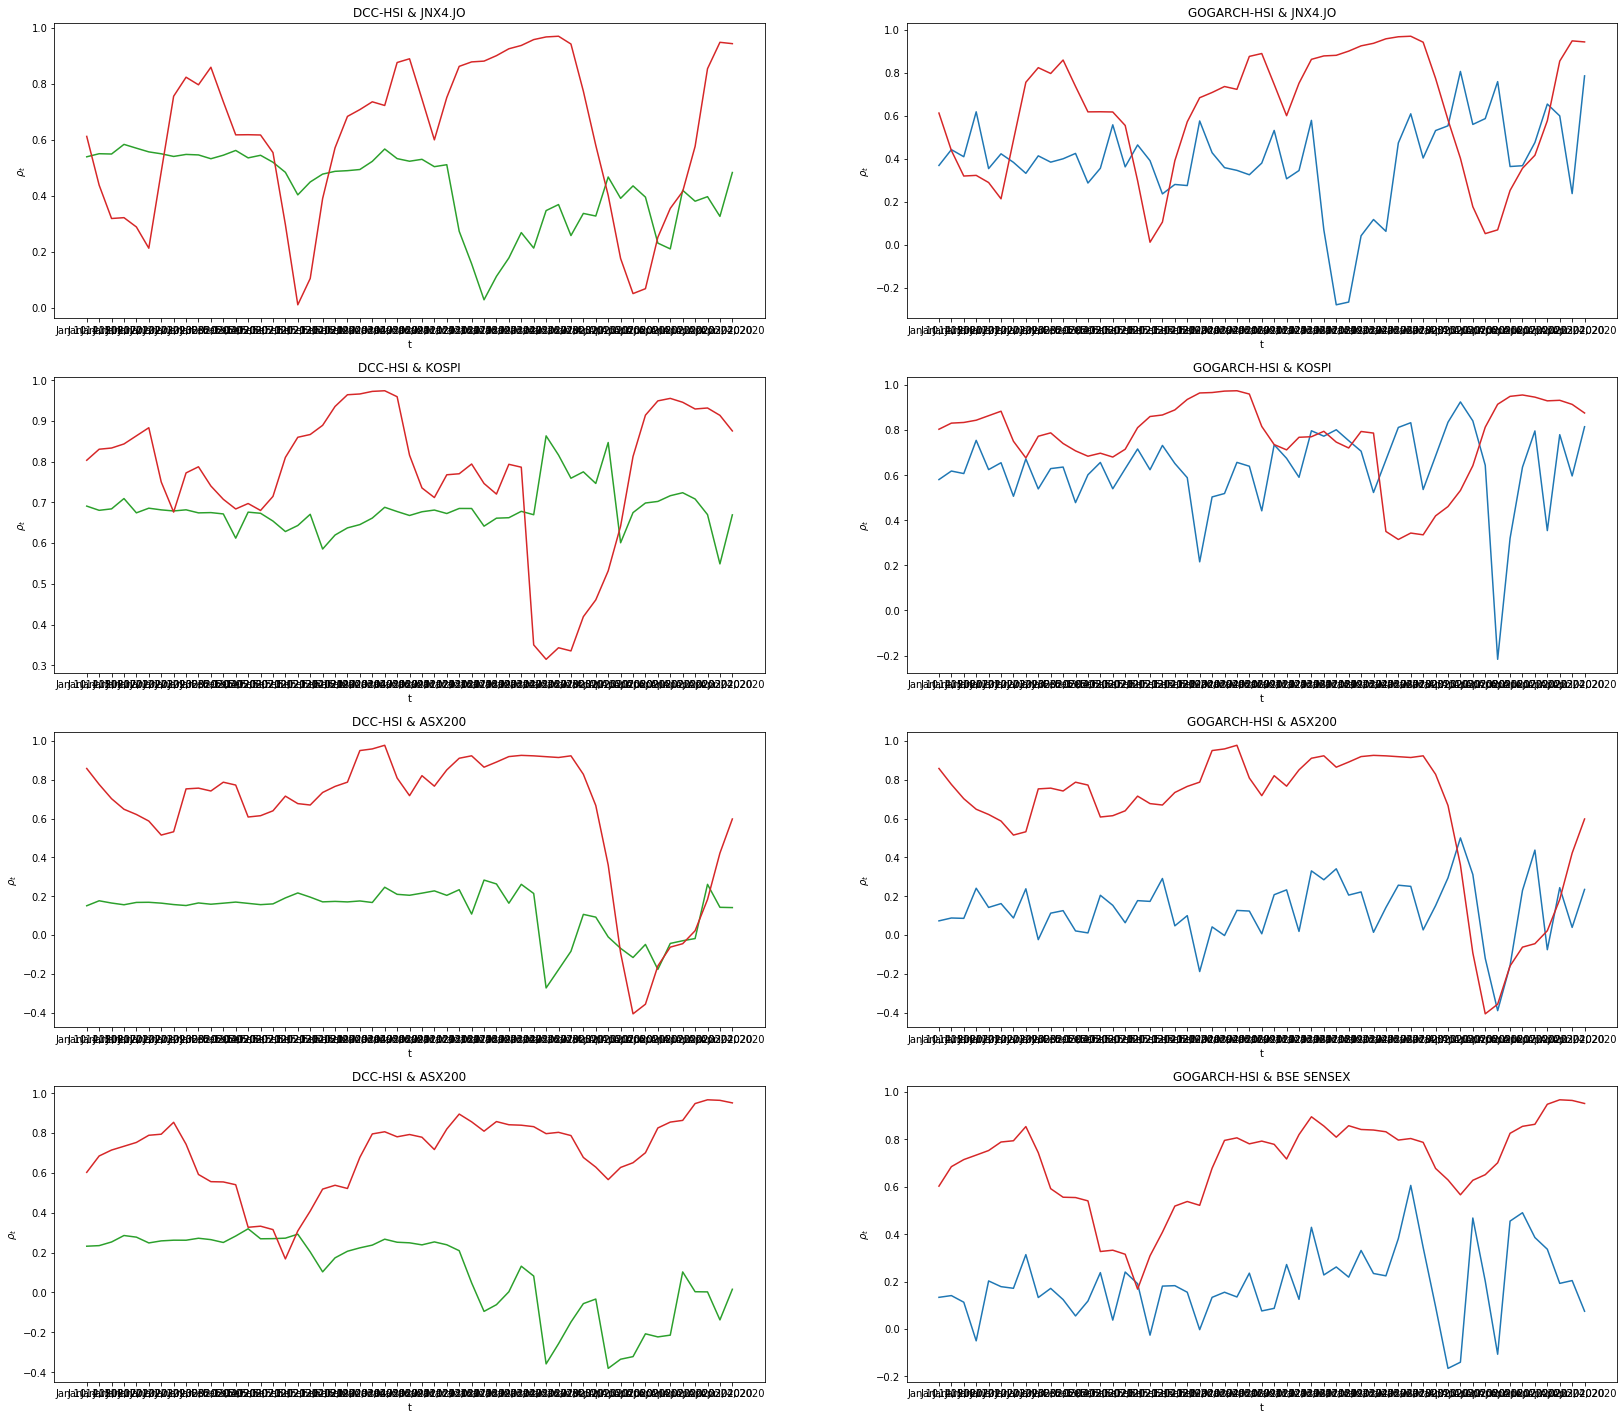

In [188]:
#Separate and plot all of HONG-KONG's remaining forecasted and actual correlations (for comparison)
rho_dcc_hk_sa = rho_dcc[5,6,:]
rho_dcc_hk_sa = pd.Series(rho_dcc_hk_sa, index=df_test_corr.index, name='Corr_HK_SA')

rho_gogarch_hk_sa = rho_gogarch[5,6,:]
rho_gogarch_hk_sa = pd.Series(rho_gogarch_hk_sa, index=df_test_corr.index, name='Corr_HK_SA')

rho_dcc_hk_sk = rho_dcc[5,7,:]
rho_dcc_hk_sk = pd.Series(rho_dcc_hk_sk, index=df_test_corr.index, name='Corr_HK_SK')

rho_gogarch_hk_sk = rho_gogarch[5,7,:]
rho_gogarch_hk_sk = pd.Series(rho_gogarch_hk_sk, index=df_test_corr.index, name='Corr_HK_SK')

rho_dcc_hk_au = rho_dcc[5,8,:]
rho_dcc_hk_au = pd.Series(rho_dcc_hk_au, index=df_test_corr.index, name='Corr_HK_AU')

rho_gogarch_hk_au = rho_gogarch[5,8,:]
rho_gogarch_hk_au = pd.Series(rho_gogarch_hk_au, index=df_test_corr.index, name='Corr_HK_AU')

rho_dcc_hk_ind = rho_dcc[5,9,:]
rho_dcc_hk_ind = pd.Series(rho_dcc_hk_ind, index=df_test_corr.index, name='Corr_HK_IND')

rho_gogarch_hk_ind = rho_gogarch[5,9,:]
rho_gogarch_hk_ind = pd.Series(rho_gogarch_hk_ind, index=df_test_corr.index, name='Corr_HK_IND')

fig,ax = plt.subplots(nrows=4, ncols=2, figsize=(28,25));
ax[0,0].plot(rho_dcc_hk_sa.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,35], 'tab:red')
ax[0,0].set_title('DCC-HSI & JNX4.JO')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_hk_sa.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,35], 'tab:red')
ax[0,1].set_title('GOGARCH-HSI & JNX4.JO')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[1,0].plot(rho_dcc_hk_sk.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,36], 'tab:red')
ax[1,0].set_title('DCC-HSI & KOSPI')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_hk_sk.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,36], 'tab:red')
ax[1,1].set_title('GOGARCH-HSI & KOSPI')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');
ax[2,0].plot(rho_dcc_hk_au.iloc[9:], 'tab:green')
ax[2,0].plot(df_test_corr.iloc[9:,37], 'tab:red')
ax[2,0].set_title('DCC-HSI & ASX200')
ax[2,0].set_ylabel(r'$\rho_{t}$')
ax[2,0].set_xlabel('t');
ax[2,1].plot(rho_gogarch_hk_au.iloc[9:], 'tab:blue')
ax[2,1].plot(df_test_corr.iloc[9:,37], 'tab:red')
ax[2,1].set_title('GOGARCH-HSI & ASX200')
ax[2,1].set_ylabel(r'$\rho_{t}$')
ax[2,1].set_xlabel('t');
ax[3,0].plot(rho_dcc_hk_ind.iloc[9:], 'tab:green')
ax[3,0].plot(df_test_corr.iloc[9:,38], 'tab:red')
ax[3,0].set_title('DCC-HSI & ASX200')
ax[3,0].set_ylabel(r'$\rho_{t}$')
ax[3,0].set_xlabel('t');
ax[3,1].plot(rho_gogarch_hk_ind.iloc[9:], 'tab:blue')
ax[3,1].plot(df_test_corr.iloc[9:,38], 'tab:red')
ax[3,1].set_title('GOGARCH-HSI & BSE SENSEX')
ax[3,1].set_ylabel(r'$\rho_{t}$')
ax[3,1].set_xlabel('t');

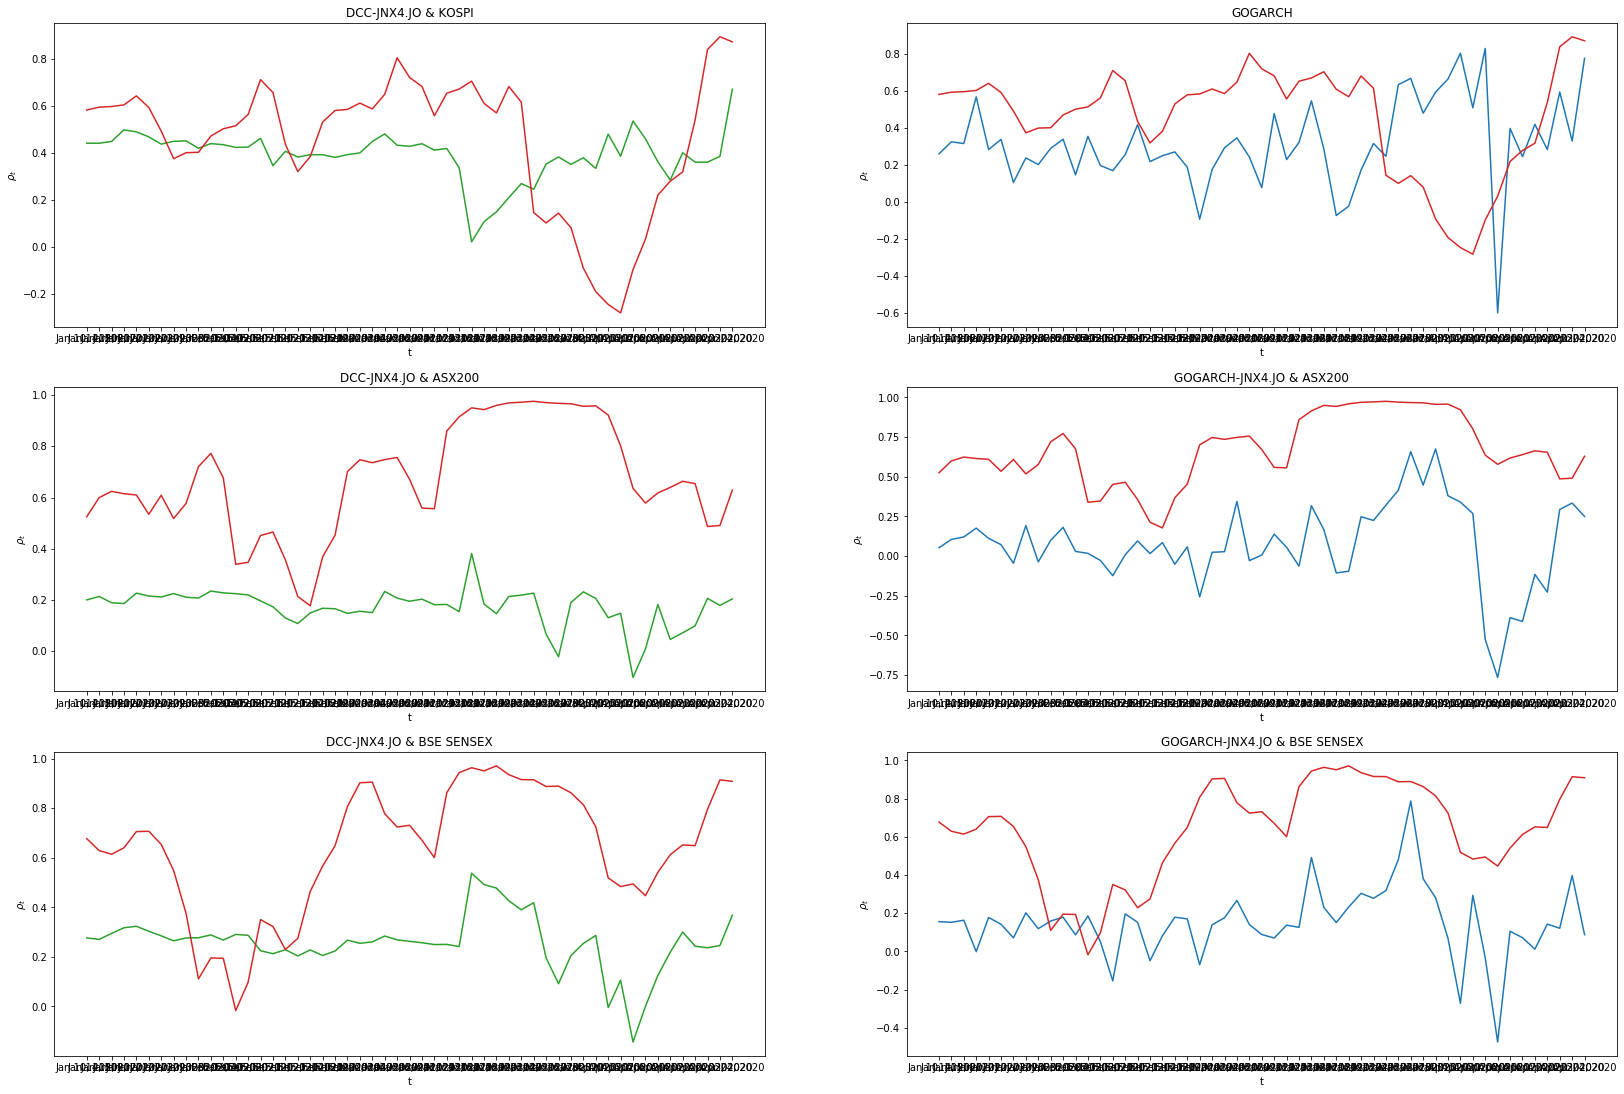

In [186]:
#Separate and plot all of SOUTH-AFRICA's remaining forecasted and actual correlations (for comparison)
rho_dcc_sa_sk = rho_dcc[6,7,:]
rho_dcc_sa_sk = pd.Series(rho_dcc_sa_sk, index=df_test_corr.index, name='Corr_SA_SK')

rho_gogarch_sa_sk = rho_gogarch[6,7,:]
rho_gogarch_sa_sk = pd.Series(rho_gogarch_sa_sk, index=df_test_corr.index, name='Corr_SA_SK')

rho_dcc_sa_au = rho_dcc[6,8,:]
rho_dcc_sa_au = pd.Series(rho_dcc_sa_au, index=df_test_corr.index, name='Corr_SA_AU')

rho_gogarch_sa_au = rho_gogarch[6,8,:]
rho_gogarch_sa_au = pd.Series(rho_gogarch_sa_au, index=df_test_corr.index, name='Corr_SA_AU')

rho_dcc_sa_ind = rho_dcc[6,9,:]
rho_dcc_sa_ind = pd.Series(rho_dcc_sa_ind, index=df_test_corr.index, name='Corr_SA_IND')

rho_gogarch_sa_ind = rho_gogarch[6,9,:]
rho_gogarch_sa_ind = pd.Series(rho_gogarch_sa_ind, index=df_test_corr.index, name='Corr_SA_IND')

fig,ax = plt.subplots(nrows=3, ncols=2, figsize=(28,19));
ax[0,0].plot(rho_dcc_sa_sk.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,39], 'tab:red')
ax[0,0].set_title('DCC-JNX4.JO & KOSPI')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_sa_sk.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,39], 'tab:red')
ax[0,1].set_title('GOGARCH-JNX4.JO & KOSPI')
ax[0,1].set_title('GOGARCH')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[1,0].plot(rho_dcc_sa_au.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,40], 'tab:red')
ax[1,0].set_title('DCC-JNX4.JO & ASX200')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_sa_au.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,40], 'tab:red')
ax[1,1].set_title('GOGARCH-JNX4.JO & ASX200')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');
ax[2,0].plot(rho_dcc_sa_ind.iloc[9:], 'tab:green')
ax[2,0].plot(df_test_corr.iloc[9:,41], 'tab:red')
ax[2,0].set_title('DCC-JNX4.JO & BSE SENSEX')
ax[2,0].set_ylabel(r'$\rho_{t}$')
ax[2,0].set_xlabel('t');
ax[2,1].plot(rho_gogarch_sa_ind.iloc[9:], 'tab:blue')
ax[2,1].plot(df_test_corr.iloc[9:,41], 'tab:red')
ax[2,1].set_title('GOGARCH-JNX4.JO & BSE SENSEX')
ax[2,1].set_ylabel(r'$\rho_{t}$')
ax[2,1].set_xlabel('t');

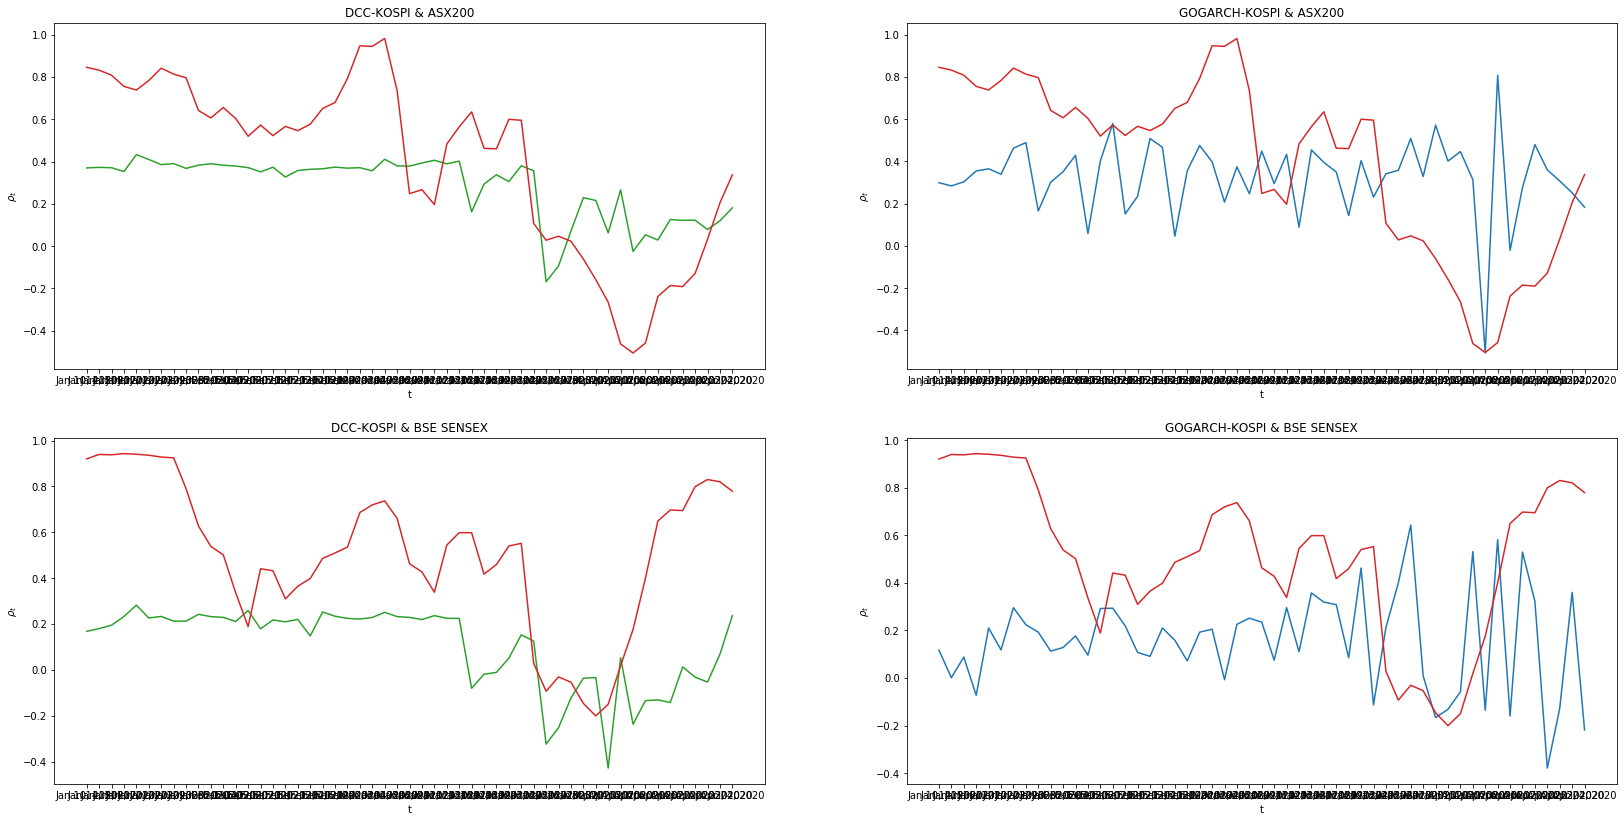

In [178]:
#Separate and plot all of SOUTH-KOREA's remaining forecasted and actual correlations (for comparison)
rho_dcc_sk_au = rho_dcc[7,8,:]
rho_dcc_sk_au = pd.Series(rho_dcc_sk_au, index=df_test_corr.index, name='Corr_SK_AU')

rho_gogarch_sk_au = rho_gogarch[7,8,:]
rho_gogarch_sk_au = pd.Series(rho_gogarch_sk_au, index=df_test_corr.index, name='Corr_SK_AU')

rho_dcc_sk_ind = rho_dcc[7,9,:]
rho_dcc_sk_ind = pd.Series(rho_dcc_sk_ind, index=df_test_corr.index, name='Corr_SK_IND')

rho_gogarch_sk_ind = rho_gogarch[7,9,:]
rho_gogarch_sk_ind = pd.Series(rho_gogarch_sk_ind, index=df_test_corr.index, name='Corr_SK_IND')

fig,ax = plt.subplots(nrows=2, ncols=2, figsize=(28,14));
ax[0,0].plot(rho_dcc_sk_au.iloc[9:], 'tab:green')
ax[0,0].plot(df_test_corr.iloc[9:,42], 'tab:red')
ax[0,0].set_title('DCC-KOSPI & ASX200')
ax[0,0].set_ylabel(r'$\rho_{t}$')
ax[0,0].set_xlabel('t');
ax[0,1].plot(rho_gogarch_sk_au.iloc[9:], 'tab:blue')
ax[0,1].plot(df_test_corr.iloc[9:,42], 'tab:red')
ax[0,1].set_title('GOGARCH-KOSPI & ASX200')
ax[0,1].set_ylabel(r'$\rho_{t}$')
ax[0,1].set_xlabel('t');
ax[1,0].plot(rho_dcc_sk_ind.iloc[9:], 'tab:green')
ax[1,0].plot(df_test_corr.iloc[9:,43], 'tab:red')
ax[1,0].set_title('DCC-KOSPI & BSE SENSEX')
ax[1,0].set_ylabel(r'$\rho_{t}$')
ax[1,0].set_xlabel('t');
ax[1,1].plot(rho_gogarch_sk_ind.iloc[9:], 'tab:blue')
ax[1,1].plot(df_test_corr.iloc[9:,43], 'tab:red')
ax[1,1].set_title('GOGARCH-KOSPI & BSE SENSEX')
ax[1,1].set_ylabel(r'$\rho_{t}$')
ax[1,1].set_xlabel('t');

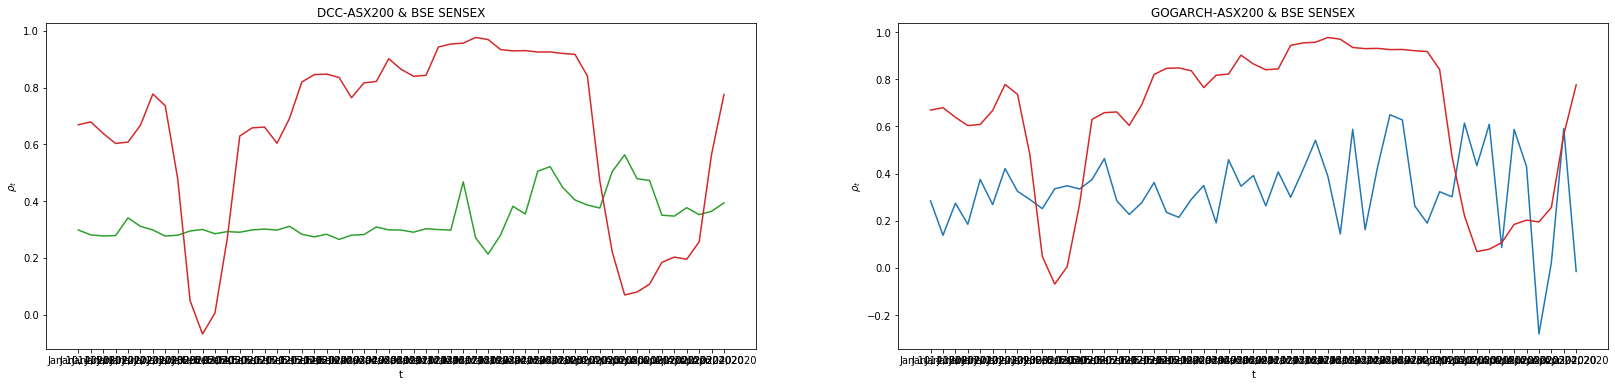

In [176]:
#Separate and plot all of INDIA's remaining forecasted and actual correlations (for comparison)
rho_dcc_au_ind = rho_dcc[8,9,:]
rho_dcc_au_ind = pd.Series(rho_dcc_au_ind, index=df_test_corr.index, name='Corr_AU_IND')

rho_gogarch_au_ind = rho_gogarch[8,9,:]
rho_gogarch_au_ind = pd.Series(rho_gogarch_au_ind, index=df_test_corr.index, name='Corr_AU_IND')

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(28,6));
ax[0].plot(rho_dcc_au_ind.iloc[9:], 'tab:green')
ax[0].plot(df_test_corr.iloc[9:,44], 'tab:red')
ax[0].set_title('DCC-ASX200 & BSE SENSEX')
ax[0].set_ylabel(r'$\rho_{t}$')
ax[0].set_xlabel('t');
ax[1].plot(rho_gogarch_au_ind.iloc[9:], 'tab:blue')
ax[1].plot(df_test_corr.iloc[9:,44], 'tab:red')
ax[1].set_title('GOGARCH-ASX200 & BSE SENSEX')
ax[1].set_ylabel(r'$\rho_{t}$')
ax[1].set_xlabel('t');

In [61]:
#Create proxied actual volatilities (squared returns) over test subset
df_test_vol = pd.DataFrame(df_test2).copy()

for i in range(0,df_test2.shape[1]):
    df_test_vol.iloc[:,i]=df_test2.iloc[:,i]**2

print(df_test_vol)

              log_ret_USA  log_ret_JAP  log_ret_NL   log_ret_GER   log_ret_BR  \
Date                                                                            
Dec 19, 2019     1.631179     0.970586    0.331296  6.650950e-01     5.009631   
Dec 20, 2019     0.193473     0.028455    0.399720  6.578460e-01     0.004376   
Dec 23, 2019     0.207029     0.017470    1.440166  1.665562e+00     1.879983   
Dec 27, 2019     0.664981     0.028951    0.776177  5.103878e-01     0.512894   
Dec 30, 2019     2.201955     0.780120    2.087301  6.349273e+00     1.005568   
Jan 06, 2020     5.893530     0.110996    4.966821  2.286219e+01     5.490601   
Jan 07, 2020     5.789036    21.894815    0.828789  1.556120e+01     5.042173   
Jan 08, 2020     3.324293    44.692692    0.205400  6.439309e+00     0.637892   
Jan 09, 2020     0.354609    49.525140    0.242101  2.818619e+00     0.072545   
Jan 10, 2020     1.262301    32.267672    0.805508  6.311390e-03     0.049828   
Jan 14, 2020     3.164148   

In [60]:
#Identify and separate forecasted standard deviations for individual stock indices
sigma_dcc = pandas2ri.ri2py(rugarch.sigma(dcc_fore))
sigma_dcc = np.concatenate(sigma_dcc,axis=1)
sigma_dcc_usa = sigma_dcc[0,:]
sigma_dcc_jap = sigma_dcc[1,:]
sigma_dcc_nl = sigma_dcc[2,:]
sigma_dcc_ger = sigma_dcc[3,:]
sigma_dcc_br = sigma_dcc[4,:]
sigma_dcc_hk = sigma_dcc[5,:]
sigma_dcc_sa = sigma_dcc[6,:]
sigma_dcc_sk = sigma_dcc[7,:]
sigma_dcc_au = sigma_dcc[8,:]
sigma_dcc_ind = sigma_dcc[9,:]

sigma_gogarch = pandas2ri.ri2py(rugarch.sigma(gogarch_fore))
sigma_gogarch = np.concatenate(sigma_gogarch,axis=1)
sigma_gogarch_usa = sigma_gogarch[0,:]
sigma_gogarch_jap = sigma_gogarch[1,:]
sigma_gogarch_nl = sigma_gogarch[2,:]
sigma_gogarch_ger = sigma_gogarch[3,:]
sigma_gogarch_br = sigma_gogarch[4,:]
sigma_gogarch_hk = sigma_gogarch[5,:]
sigma_gogarch_sa = sigma_gogarch[6,:]
sigma_gogarch_sk = sigma_gogarch[7,:]
sigma_gogarch_au = sigma_gogarch[8,:]
sigma_gogarch_ind = sigma_gogarch[9,:]
print(sigma_dcc_usa, sigma_gogarch_usa)

[0.41935713 0.40712937 0.4090215  0.41074719 0.41667739 0.412396
 0.41710983 0.4116191  0.44973585 0.40692962 0.40770076 0.40920418
 0.41465594 0.40825377 0.41820158 0.41536289 0.40869133 0.40776877
 0.41468242 0.41123825 0.40812117 0.41279105 0.41154554 0.40960285
 0.41815065 0.41604023 0.40864238 0.41571033 0.41459457 0.40703883
 0.40819582 0.41525168 0.41805613 0.41270244 0.43117673 0.43033321
 0.41052609 0.41331826 0.42285319 0.41865089 0.43448216 0.60669147
 0.41600479 0.4887709  0.45451261 0.408801   0.42931169 0.41872534
 0.49488487 0.52887415 0.42242321 0.51995283 0.46343896 0.47528745
 0.49106209 0.85404086 0.45245724 0.52468281 0.62151222 0.61567564
 0.5010409  0.54069213] [0.48269084 0.49070386 0.4872295  0.47077087 0.52163528 0.48547378
 0.57144838 0.51016119 0.50324914 0.48286652 0.49691043 0.48926041
 0.4707825  0.4718384  0.52363234 0.48098692 0.4788971  0.49562446
 0.47175152 0.48345379 0.47105022 0.48503809 0.49864404 0.47959481
 0.61966172 0.6452888  0.47580489 0.4715

In [116]:
#Subtract the estimated Go-GARCH volatilities from actual volatilities for each stock index
diff_vol_gogarch_usa = df_test_vol.iloc[:,0].subtract(sigma_gogarch_usa**2)
diff_vol_gogarch_jap = df_test_vol.iloc[:,1].subtract(sigma_gogarch_jap**2)
diff_vol_gogarch_nl = df_test_vol.iloc[:,2].subtract(sigma_gogarch_nl**2)
diff_vol_gogarch_ger = df_test_vol.iloc[:,3].subtract(sigma_gogarch_ger**2)
diff_vol_gogarch_br = df_test_vol.iloc[:,4].subtract(sigma_gogarch_br**2)
diff_vol_gogarch_hk = df_test_vol.iloc[:,5].subtract(sigma_gogarch_hk**2)
diff_vol_gogarch_sa = df_test_vol.iloc[:,6].subtract(sigma_gogarch_sa**2)
diff_vol_gogarch_sk = df_test_vol.iloc[:,7].subtract(sigma_gogarch_sk**2)
diff_vol_gogarch_au = df_test_vol.iloc[:,8].subtract(sigma_gogarch_au**2)
diff_vol_gogarch_ind = df_test_vol.iloc[:,9].subtract(sigma_gogarch_ind**2)

In [115]:
#Subtract the estimated DCC volatilities from actual volatilities for each stock index
diff_vol_dcc_usa = df_test_vol.iloc[:,0].subtract(sigma_dcc_usa**2)
diff_vol_dcc_jap = df_test_vol.iloc[:,1].subtract(sigma_dcc_jap**2)
diff_vol_dcc_nl = df_test_vol.iloc[:,2].subtract(sigma_dcc_nl**2)
diff_vol_dcc_ger = df_test_vol.iloc[:,3].subtract(sigma_dcc_ger**2)
diff_vol_dcc_br = df_test_vol.iloc[:,4].subtract(sigma_dcc_br**2)
diff_vol_dcc_hk = df_test_vol.iloc[:,5].subtract(sigma_dcc_hk**2)
diff_vol_dcc_sa = df_test_vol.iloc[:,6].subtract(sigma_dcc_sa**2)
diff_vol_dcc_sk = df_test_vol.iloc[:,7].subtract(sigma_dcc_sk**2)
diff_vol_dcc_au = df_test_vol.iloc[:,8].subtract(sigma_dcc_au**2)
diff_vol_dcc_ind = df_test_vol.iloc[:,9].subtract(sigma_dcc_ind**2)

In [125]:
#Create 95% DCC Bootstrap Confidence Intervals for stock index volatilities
iterations=1000
bootstrap=53
stats_usa = list()
stats_jap = list()
stats_nl = list()
stats_ger = list()
stats_br = list()
stats_hk = list()
stats_sa = list()
stats_sk = list()
stats_au = list()
stats_ind = list()

for i in range(iterations):
        sample_usa = resample(diff_vol_dcc_usa, n_samples=bootstrap)
        mean_usa = np.mean(sample_usa)
        stats_usa.append(mean_usa)
        sample_jap = resample(diff_vol_dcc_jap, n_samples=bootstrap)
        mean_jap = np.mean(sample_jap)
        stats_jap.append(mean_jap)
        sample_nl = resample(diff_vol_dcc_nl, n_samples=bootstrap)
        mean_nl = np.mean(sample_nl)
        stats_nl.append(mean_nl)
        sample_ger = resample(diff_vol_dcc_ger, n_samples=bootstrap)
        mean_ger = np.mean(sample_ger)
        stats_ger.append(mean_ger)
        sample_br = resample(diff_vol_dcc_br, n_samples=bootstrap)
        mean_br = np.mean(sample_br)
        stats_br.append(mean_br)
        sample_hk = resample(diff_vol_dcc_hk, n_samples=bootstrap)
        mean_hk = np.mean(sample_hk)
        stats_hk.append(mean_hk)
        sample_sa = resample(diff_vol_dcc_sa, n_samples=bootstrap)
        mean_sa = np.mean(sample_sa)
        stats_sa.append(mean_sa)
        sample_sk = resample(diff_vol_dcc_sk, n_samples=bootstrap)
        mean_sk = np.mean(sample_sk)
        stats_sk.append(mean_sk)
        sample_au = resample(diff_vol_dcc_au, n_samples=bootstrap)
        mean_au = np.mean(sample_au)
        stats_au.append(mean_au)
        sample_ind = resample(diff_vol_dcc_ind, n_samples=bootstrap)
        mean_ind = np.mean(sample_ind)
        stats_ind.append(mean_ind)
        
    
# confidence intervals
alpha = 0.95
p1 = ((1.0-alpha)/2.0) * 100
p2 = (alpha+((1.0-alpha)/2.0)) * 100

print("USA:")
lower = np.percentile(stats_usa, p1)
upper = np.percentile(stats_usa, p2)
print(alpha*100, lower, upper)

print("JAP:")
lower = np.percentile(stats_jap, p1)
upper = np.percentile(stats_jap, p2)
print(alpha*100, lower, upper)

print("NL:")
lower = np.percentile(stats_nl, p1)
upper = np.percentile(stats_nl, p2)
print(alpha*100, lower, upper)
    
print("GER:")
lower = np.percentile(stats_ger, p1)
upper = np.percentile(stats_ger, p2)
print(alpha*100, lower, upper)
    
print("BR:")
lower = np.percentile(stats_br, p1)
upper = np.percentile(stats_br, p2)
print(alpha*100, lower, upper)
    
print("HK:")
lower = np.percentile(stats_hk, p1)
upper = np.percentile(stats_hk, p2)
print(alpha*100, lower, upper)
    
print("SA:")
lower = np.percentile(stats_sa, p1)
upper = np.percentile(stats_sa, p2)
print(alpha*100, lower, upper)
    
print("SK:")
lower = np.percentile(stats_sk, p1)
upper = np.percentile(stats_sk, p2)
print(alpha*100, lower, upper)
    
print("AU:")
lower = np.percentile(stats_au, p1)
upper = np.percentile(stats_au, p2)
print(alpha*100, lower, upper)
    
print("IND:")
lower = np.percentile(stats_ind, p1)
upper = np.percentile(stats_ind, p2)
print(alpha*100, lower, upper)

USA:
95.0 66.5123382832849 242.24415657797928
JAP:
95.0 11.908223892976695 44.55668569806982
NL:
95.0 23.291080405791284 68.42293597315454
GER:
95.0 41.33869897142063 134.80704789269856
BR:
95.0 78.99835385031908 389.4680897713314
HK:
95.0 11.750269378769948 25.61216555749483
SA:
95.0 28.040274402056728 84.66732634998009
SK:
95.0 10.433303358263382 29.391334058670843
AU:
95.0 31.48874424398186 107.04396143734515
IND:
95.0 30.952404853946074 95.22192853421653


In [126]:
#Create 95% GO-GARCH Bootstrap Confidence Intervals for stock index volatilities
iterations=1000
bootstrap=53
stats_usa = list()
stats_jap = list()
stats_nl = list()
stats_ger = list()
stats_br = list()
stats_hk = list()
stats_sa = list()
stats_sk = list()
stats_au = list()
stats_ind = list()

for i in range(iterations):
        sample_usa = resample(diff_vol_gogarch_usa, n_samples=bootstrap)
        mean_usa = np.mean(sample_usa)
        stats_usa.append(mean_usa)
        sample_jap = resample(diff_vol_gogarch_jap, n_samples=bootstrap)
        mean_jap = np.mean(sample_jap)
        stats_jap.append(mean_jap)
        sample_nl = resample(diff_vol_gogarch_nl, n_samples=bootstrap)
        mean_nl = np.mean(sample_nl)
        stats_nl.append(mean_nl)
        sample_ger = resample(diff_vol_gogarch_ger, n_samples=bootstrap)
        mean_ger = np.mean(sample_ger)
        stats_ger.append(mean_ger)
        sample_br = resample(diff_vol_gogarch_br, n_samples=bootstrap)
        mean_br = np.mean(sample_br)
        stats_br.append(mean_br)
        sample_hk = resample(diff_vol_gogarch_hk, n_samples=bootstrap)
        mean_hk = np.mean(sample_hk)
        stats_hk.append(mean_hk)
        sample_sa = resample(diff_vol_gogarch_sa, n_samples=bootstrap)
        mean_sa = np.mean(sample_sa)
        stats_sa.append(mean_sa)
        sample_sk = resample(diff_vol_gogarch_sk, n_samples=bootstrap)
        mean_sk = np.mean(sample_sk)
        stats_sk.append(mean_sk)
        sample_au = resample(diff_vol_gogarch_au, n_samples=bootstrap)
        mean_au = np.mean(sample_au)
        stats_au.append(mean_au)
        sample_ind = resample(diff_vol_gogarch_ind, n_samples=bootstrap)
        mean_ind = np.mean(sample_ind)
        stats_ind.append(mean_ind)
        
    
# confidence intervals
alpha = 0.95
p1 = ((1.0-alpha)/2.0) * 100
p2 = (alpha+((1.0-alpha)/2.0)) * 100

print("USA:")
lower = np.percentile(stats_usa, p1)
upper = np.percentile(stats_usa, p2)
print(alpha*100, lower, upper)

print("JAP:")
lower = np.percentile(stats_jap, p1)
upper = np.percentile(stats_jap, p2)
print(alpha*100, lower, upper)

print("NL:")
lower = np.percentile(stats_nl, p1)
upper = np.percentile(stats_nl, p2)
print(alpha*100, lower, upper)
    
print("GER:")
lower = np.percentile(stats_ger, p1)
upper = np.percentile(stats_ger, p2)
print(alpha*100, lower, upper)
    
print("BR:")
lower = np.percentile(stats_br, p1)
upper = np.percentile(stats_br, p2)
print(alpha*100, lower, upper)
    
print("HK:")
lower = np.percentile(stats_hk, p1)
upper = np.percentile(stats_hk, p2)
print(alpha*100, lower, upper)
    
print("SA:")
lower = np.percentile(stats_sa, p1)
upper = np.percentile(stats_sa, p2)
print(alpha*100, lower, upper)
    
print("SK:")
lower = np.percentile(stats_sk, p1)
upper = np.percentile(stats_sk, p2)
print(alpha*100, lower, upper)
    
print("AU:")
lower = np.percentile(stats_au, p1)
upper = np.percentile(stats_au, p2)
print(alpha*100, lower, upper)
    
print("IND:")
lower = np.percentile(stats_ind, p1)
upper = np.percentile(stats_ind, p2)
print(alpha*100, lower, upper)

USA:
95.0 67.11622999934427 241.23281818270877
JAP:
95.0 11.21712389175814 43.07298687623697
NL:
95.0 21.501797937242593 68.32642538870137
GER:
95.0 44.32498293345798 136.68555523757826
BR:
95.0 85.09370810343282 387.3450251836315
HK:
95.0 12.589082313024539 26.9931415405448
SA:
95.0 28.87407614297629 83.70166406029402
SK:
95.0 10.539638144217408 29.87813146790058
AU:
95.0 32.13795981191617 104.48916289158521
IND:
95.0 32.414769812967656 97.69087596585565
